# QuICSeed-AI Test Notebook

This notebook runs through the process for training and testing the models evaluated in the QuICSeed-AI study.

## Universal Import of Data and Packages

In [1]:
### Import Packages
import importlib as imp
import QuICSeedIF as QuICSeedIF
imp.reload(QuICSeedIF)
import copy
import numpy as np
import tensorflow as tf
from Models import KMeansModel, SVM, MLP

In [2]:
### Import Data and Create Objects to Analyze
DATA_DIR = './Data/GrinderClean'
RANDOM_SEED = 7

# Load data using QuICSeedIF Package
qsIF = QuICSeedIF.QuICSeedIF()
qsIF.import_dataset(data_dir=DATA_DIR);
qsIF.get_dataset_statistics()

Loading Data from ./Data/GrinderClean
---- Dataset Label Distribution ----
Negative Samples: 6781
False Positive Samples: 239
Positive Samples: 991

---- Well Content Distribution: ----
Data Wells: 7027
Control Wells: 984


[6781, 239, 991, 984, 7027]

## Unsupervised
### KMeans Clustering
KMeans Clustering represents a simple, unsupervised learning method optimized for finding pattens in dataset where relationships are not necessarily known. In the case of identifying RT-QuIC curves, this is useful for finding patterns which relate to the positive/negative/false positive status of a well. KMeans represents a great baseline for comparison as it is easy to visualize and is quick to run. KMeans operates best with data which can be separated into clear clusters and struggles with overlapping datapoints. 

In [3]:
### Add 2 KMeans Models
qsIF.add_model(KMeansModel.KMeansModel(n_clusters = 3,
                                          file_path= './SavedModels/Raw/', model_name='kmeans'
                                          ), model_name='KMeans Raw', data_type='raw', tag='Unsupervised')

qsIF.add_model(KMeansModel.KMeansModel(n_clusters = 3,
                                          file_path= './SavedModels/Analysis/', model_name='kmeans'
                                          ), model_name='KMeans Metrics', data_type='analysis', tag='Unsupervised')


KMeans Model Loaded:
<class 'sklearn.cluster._kmeans.KMeans'>

KMeans Model Loaded:
<class 'sklearn.cluster._kmeans.KMeans'>


## Supervised Models

### SVM
SVMs are a powerful type of supervised learning method which draw classification boundaries in feature space, essentially drawing "lines in the sand" between classes based on feature value. SVMs are classic, simple solutions to classification problems and generally can find meaningful solutions in large dataset. SVMs are intensely limited by feature count, with each additional feature increasing the computation time dramatically. As such, SVMs often require feature engineering to be effective.

In [4]:
### SVM
qsIF.add_model(SVM.SVM(
    file_path='./SavedModels/Raw/', model_name='svm'
    ), model_name = 'SVM Raw', data_type = 'raw', tag = 'Supervised')

qsIF.add_model(SVM.SVM(file_path='./SavedModels/Analysis/', model_name='svm'), model_name = 'SVM Metrics', data_type = 'analysis', tag = 'Supervised')


SVM Model Loaded:
<class 'sklearn.svm._classes.SVC'>

SVM Model Loaded:
<class 'sklearn.svm._classes.SVC'>


### MLP
MLPs are a simple type of deep learning, able to learn complicated datasets without needing previous feature extraction. MLPs, while complicated in nature, are generally simple to implement and apply with good results. The MLP is the only model tested in this study which does not require any additional feature engineering to enable its results and lays the groundwork for more complex deep neural networks with more capabilities for the broader task of classifying Seed Amplification Assay data.

In [5]:
### MLP
qsIF.add_model(MLP.MLP(NDIM = qsIF.get_num_timesteps_raw(), 
                          file_path='./SavedModels/Raw/', model_name='mlp'
                          ), model_name = 'MLP Raw', data_type = 'raw', tag='Supervised')

\MLP Model Loaded:
<class 'keras.engine.functional.Functional'>


## Training and Evaluation

### Training
The dataset loaded in intially is separated into a training and testing set, with the test size specifying the percentage of sample wells which are included in the testing set. All control wells are included in the training data to remove any wells which may be more straightforward to classify from the training set, eliminating the potential unfair advantage this may provide to the models. Finally, each well is included at the sample level, meaning the replicates sourced from the same sample will be in the same partition of the dataset. This limits the potential for cross-contamination between the training and testing set.

The models are trained according to their own specifications.

In [6]:
### Train Models
qsIF.separate_train_test(tags=['Unsupervised', 'Supervised'], train_type=0, test_size=0.20)
qsIF.train_models(tags=['Unsupervised', 'Supervised'])

### Unsupervised Evaluation
The unsupervised models are evaluated individually for simplicity. The evaluation includes outputting scores, analyzing performance on false positives in the testing set, and generating evaluation plots for easy comparison between models. 

KMeans Raw:
              precision    recall  f1-score   support

         neg       0.94      0.99      0.96      1444
         pos       0.85      0.39      0.53       160

    accuracy                           0.93      1604
   macro avg       0.89      0.69      0.75      1604
weighted avg       0.93      0.93      0.92      1604

KMeans Metrics:
              precision    recall  f1-score   support

         neg       1.00      0.97      0.98      1444
         pos       0.78      1.00      0.87       160

    accuracy                           0.97      1604
   macro avg       0.89      0.98      0.93      1604
weighted avg       0.98      0.97      0.97      1604

-------- Results on False Positives for KMeans Raw --------
Accuracy on False Positives: 0.7608695652173914
False Positives Account for 10.09% of total misclassifications.
Misclassified FP Characteristics:
Average Time to Threshold: 30.068181818181817
Average RAF: 0.038402749545454556
Average MPR: 11.342037646181819


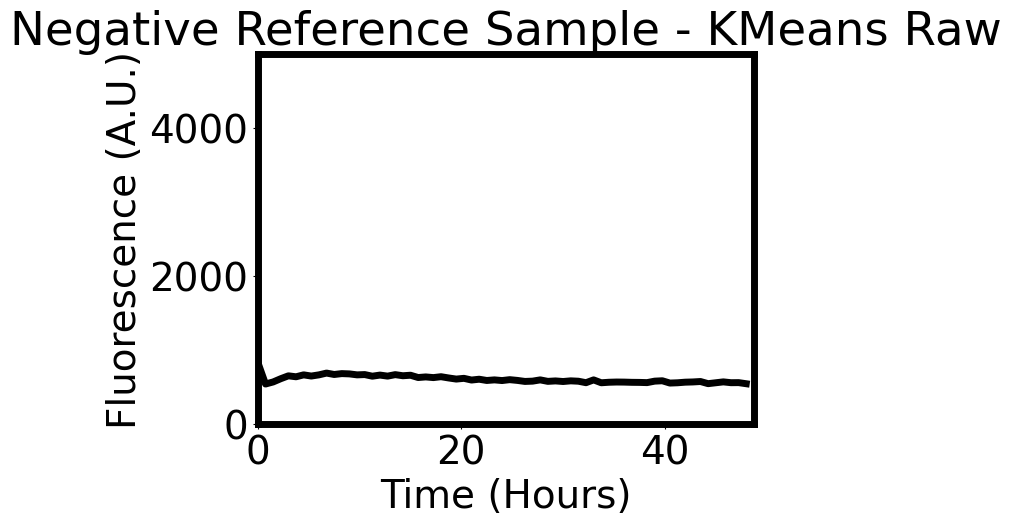

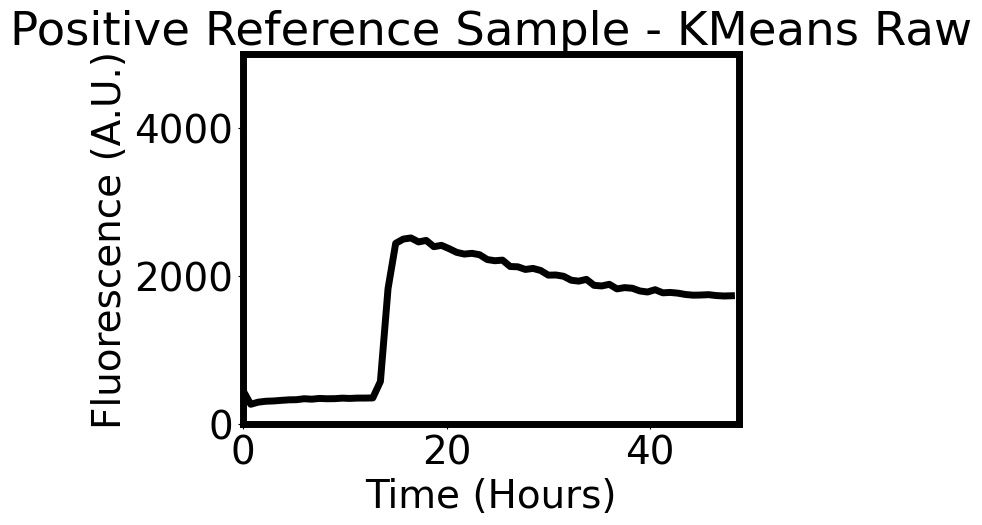

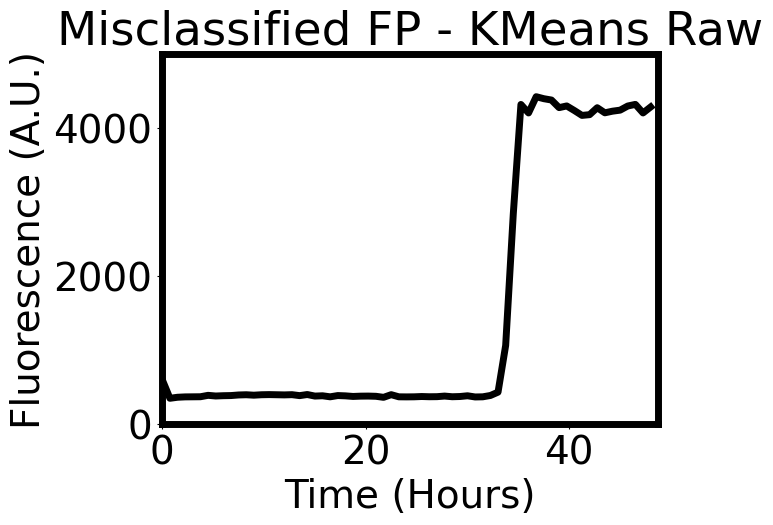

-------- Results on False Positives for KMeans Metrics --------
Accuracy on False Positives: 0.0
False Positives Account for 100.00% of total misclassifications.
Misclassified FP Characteristics:
Average Time to Threshold: 36.83152173913044
Average RAF: 0.029431402434782608
Average MPR: 8.749024480434784
Average MS: 634.6648550652175
Correctly Classified FP Characteristics:
Average Time to Threshold: nan
Average RAF: nan
Average MPR: nan
Average MS: nan


c:\Users\kyleh\anaconda3\envs\tf-keras-gpu\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\kyleh\anaconda3\envs\tf-keras-gpu\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


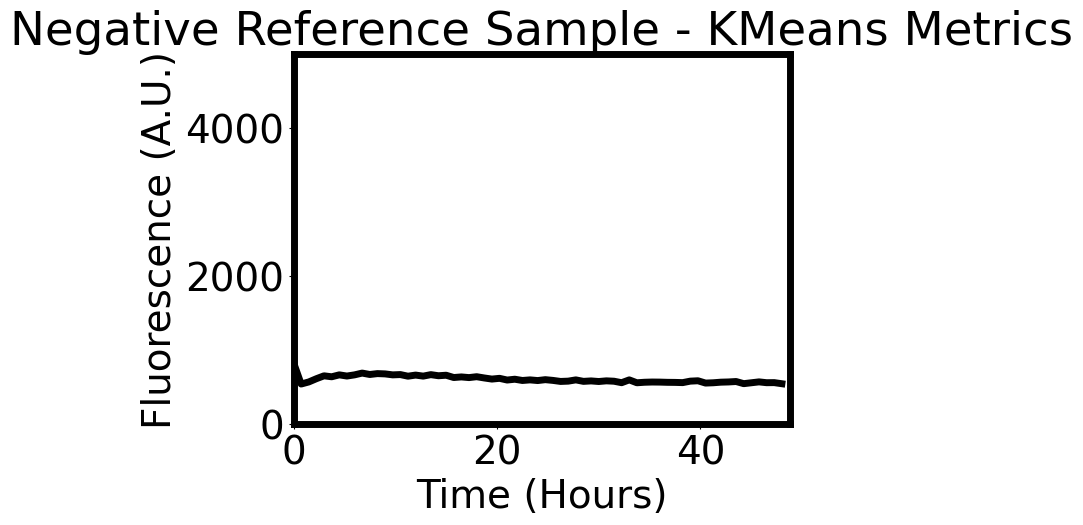

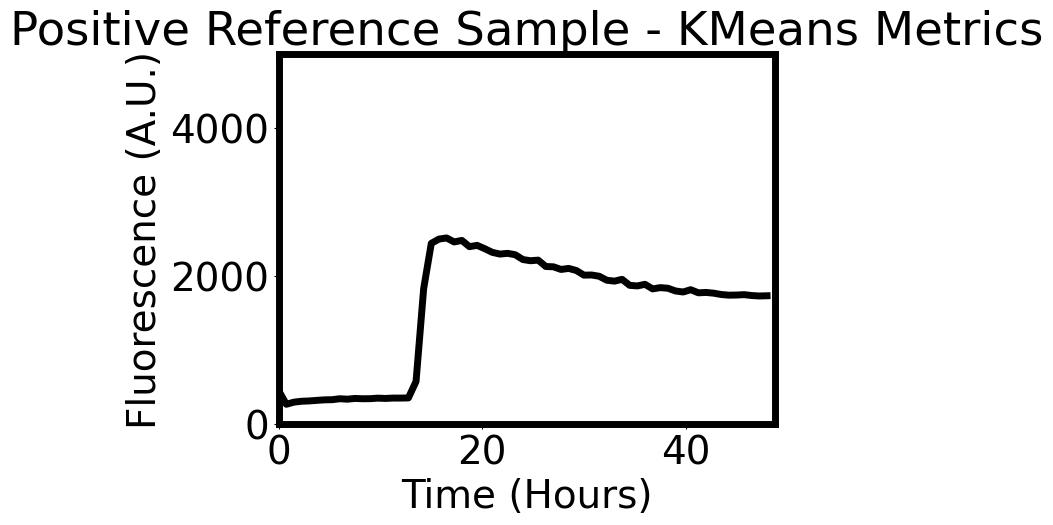

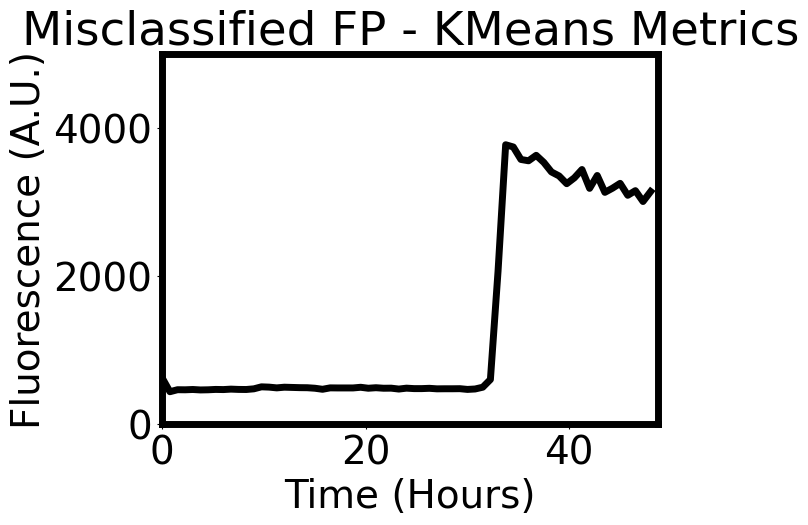

-------- Positive Characteristics for Reference --------
Time To Threshold:
	Min: 4.5, Average: 24.097911200807264, Max: 48.0
RAF:
	Min: 0.020833333, Average: 0.049054801466195765, Max: 0.222222222
MPR:
	Min: 1.241918665, Average: 11.743839485905147, Max: 54.23108384
MS:
	Min: 61.5, Average: 856.7055163084763, Max: 4282.833333


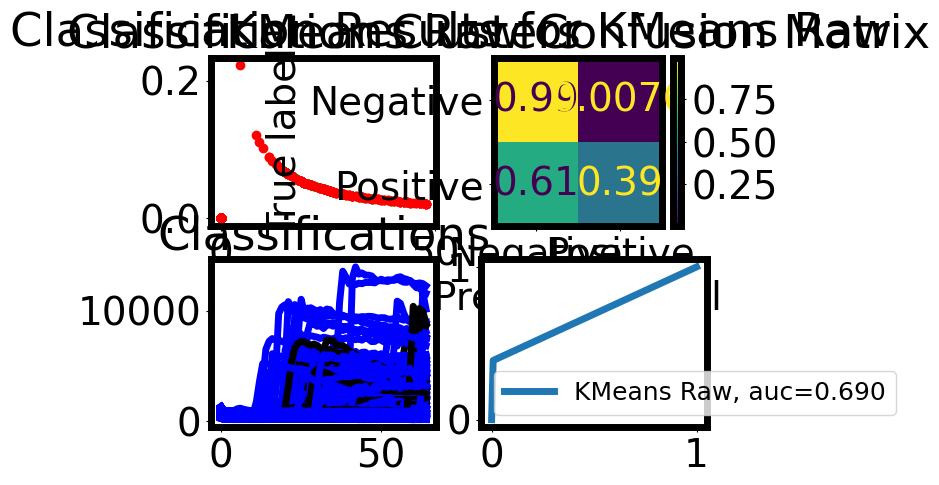

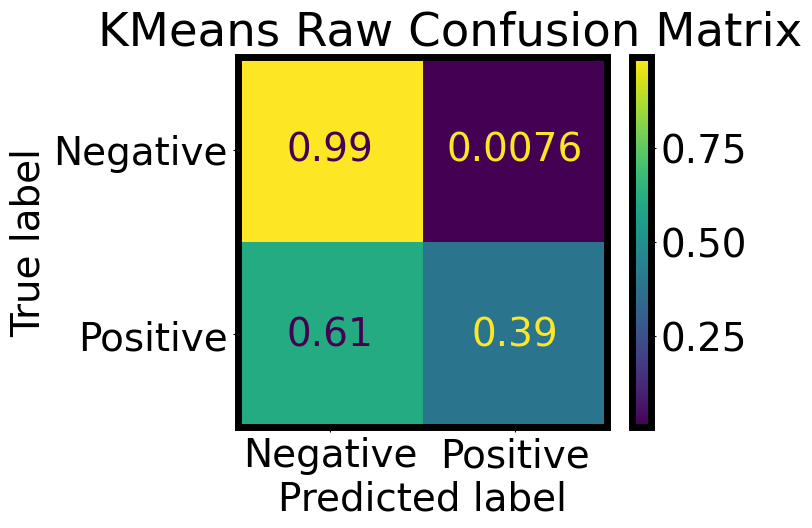

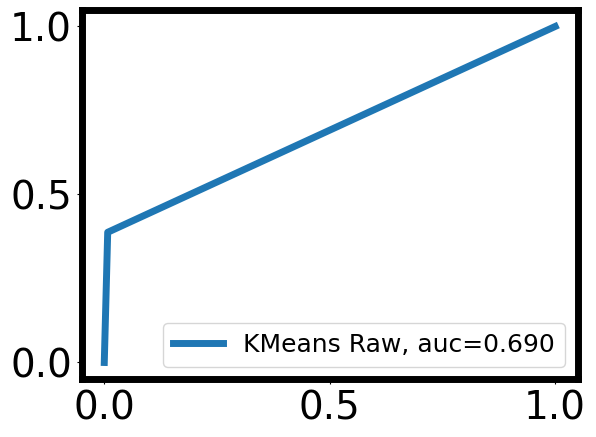

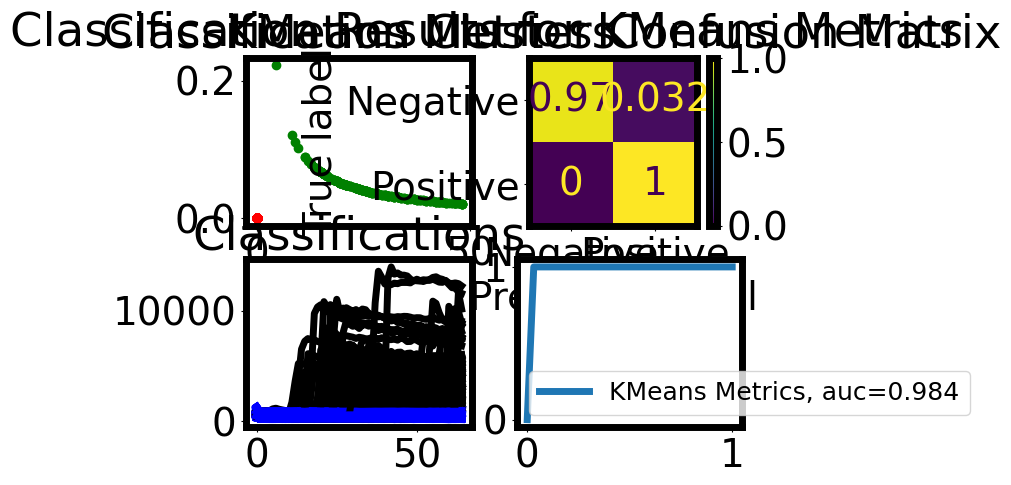

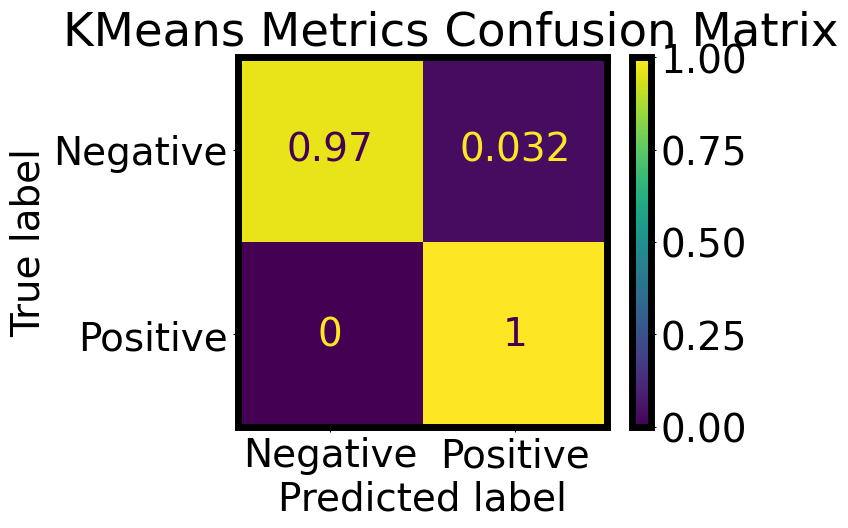

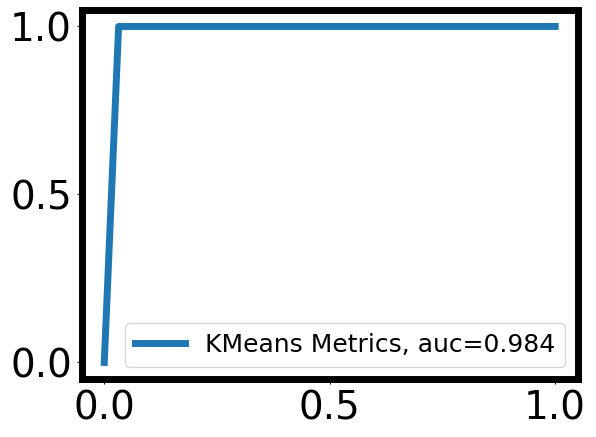

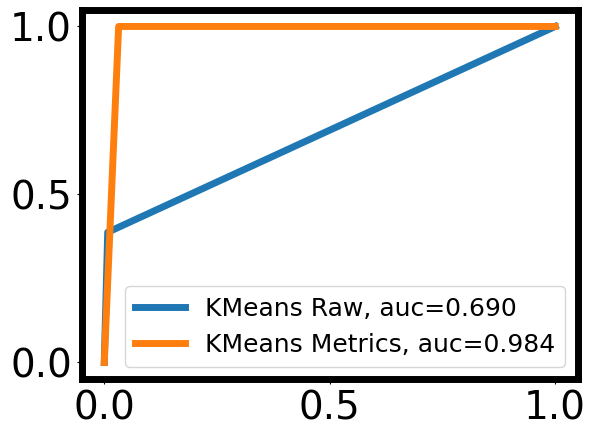

In [7]:
### Get Plots and Scores for Unsupervised Models
qsIF.get_model_scores(tags=['Unsupervised'])
qsIF.evaluate_fp_performance(tags=['Unsupervised'])
qsIF.get_model_plots(tags=['Unsupervised'])

### Supervised Evaluation
The supervised models are evaluated individually for simplicity. The evaluation includes outputting scores, analyzing performance on false positives in the testing set, and generating evaluation plots for easy comparison between models. 

SVM Raw:
              precision    recall  f1-score   support

         neg       0.99      0.93      0.96      1444
         pos       0.59      0.94      0.72       160

    accuracy                           0.93      1604
   macro avg       0.79      0.94      0.84      1604
weighted avg       0.95      0.93      0.94      1604

SVM Metrics:
              precision    recall  f1-score   support

         neg       0.99      0.98      0.99      1444
         pos       0.84      0.93      0.88       160

    accuracy                           0.98      1604
   macro avg       0.91      0.96      0.93      1604
weighted avg       0.98      0.98      0.98      1604

51/51 [==============================] - 1s 1ms/step
MLP Raw:
              precision    recall  f1-score   support

         neg       1.00      0.97      0.98      1444
         pos       0.79      0.98      0.88       160

    accuracy                           0.97      1604
   macro avg       0.90      0.98      0.93 

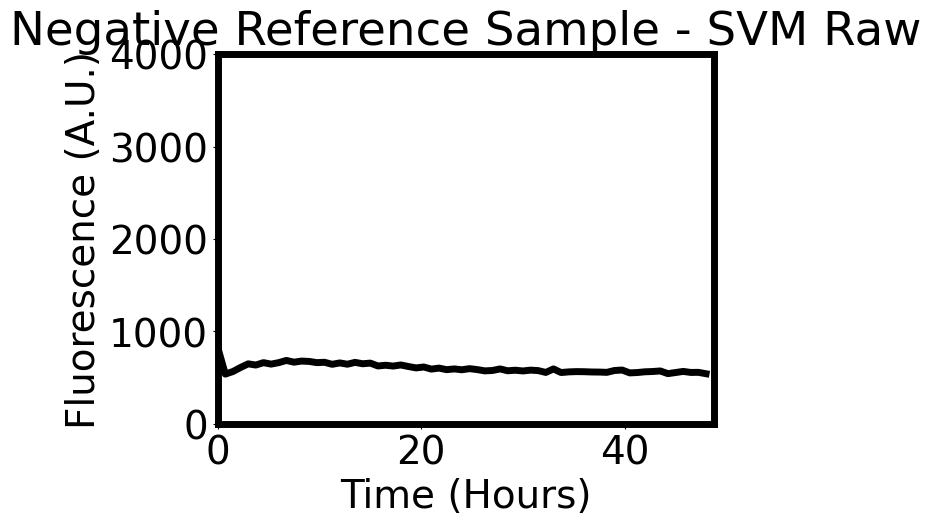

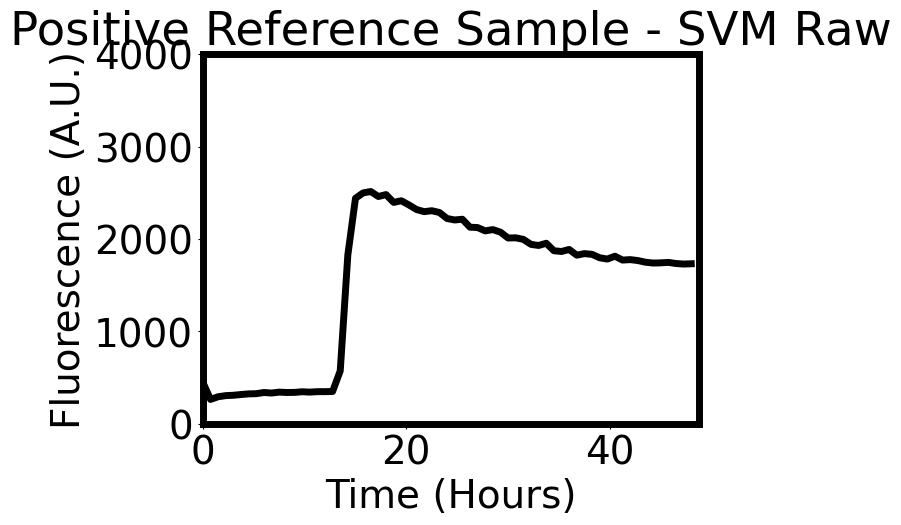

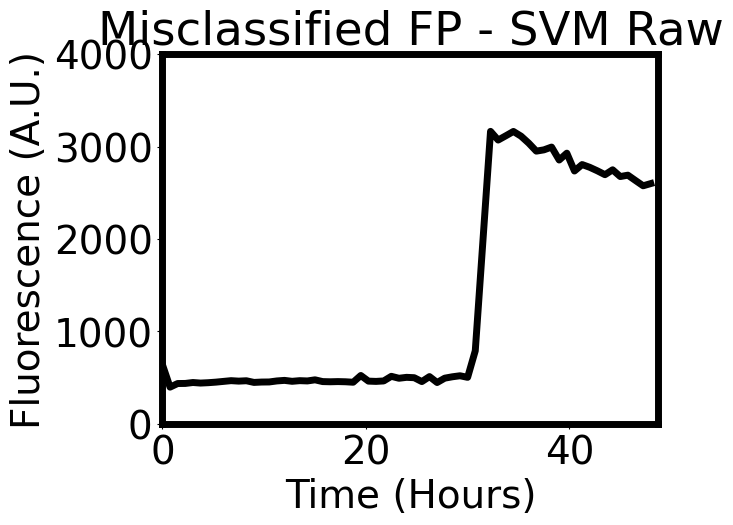

-------- Results on False Positives for SVM Metrics --------
Accuracy on False Positives: 0.3695652173913043
False Positives Account for 72.50% of total misclassifications.
Misclassified FP Characteristics:
Average Time to Threshold: 32.76724137931034
Average RAF: 0.033133249103448274
Average MPR: 10.495888140999998
Average MS: 804.0545976896552
Correctly Classified FP Characteristics:
Average Time to Threshold: 43.76470588235294
Average RAF: 0.023116487529411766
Average MPR: 5.769080588882353
Average MS: 345.70588235294116


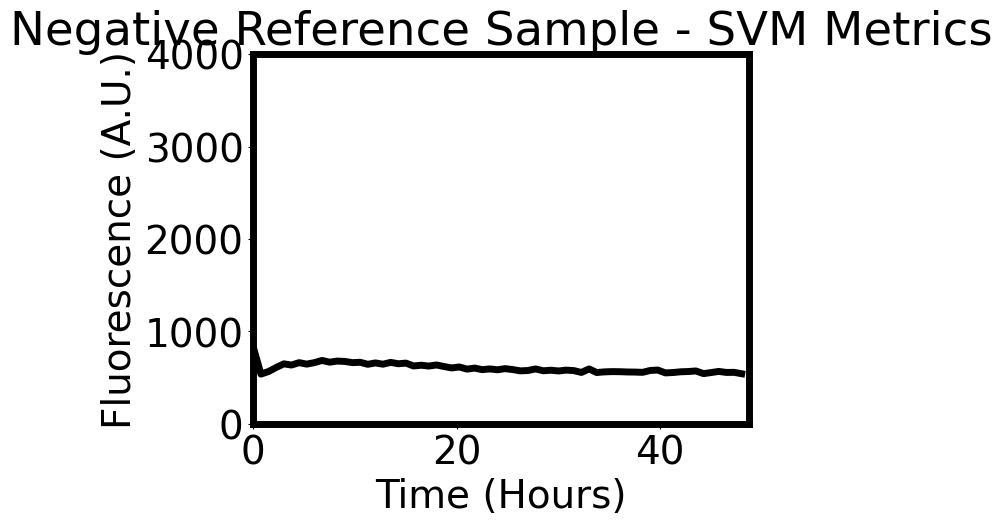

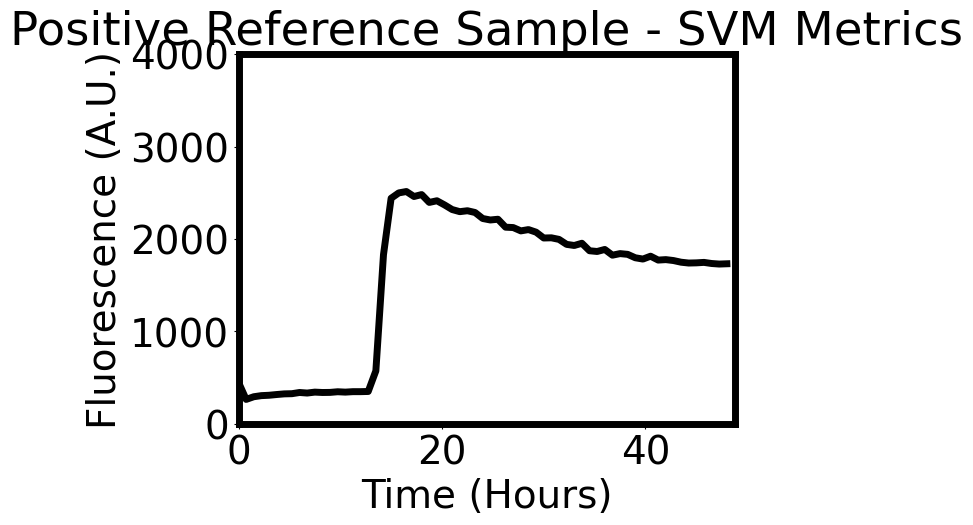

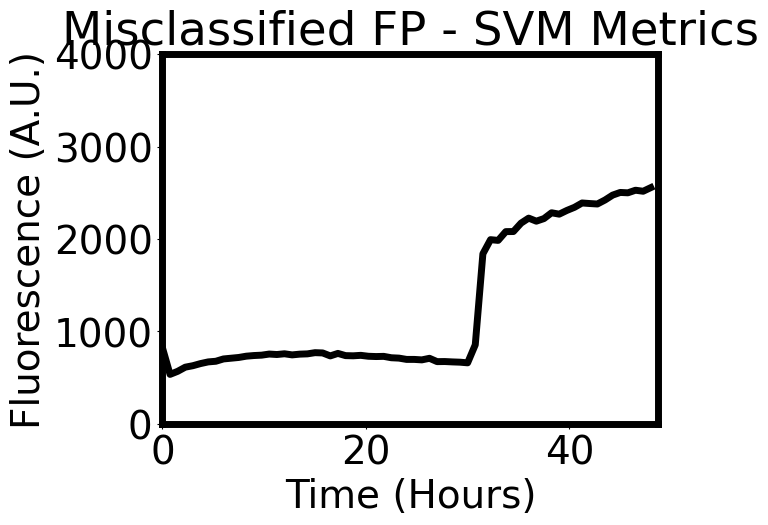

-------- Results on False Positives for MLP Raw --------
51/51 [==============================] - 0s 2ms/step
Accuracy on False Positives: 0.13043478260869565
False Positives Account for 90.91% of total misclassifications.
Misclassified FP Characteristics:
Average Time to Threshold: 36.58125
Average RAF: 0.029467505299999995
Average MPR: 9.679294233275
Average MS: 714.7833333250001
Correctly Classified FP Characteristics:
Average Time to Threshold: 38.5
Average RAF: 0.029190716666666672
Average MPR: 2.547226128166667
Average MS: 100.54166666666667


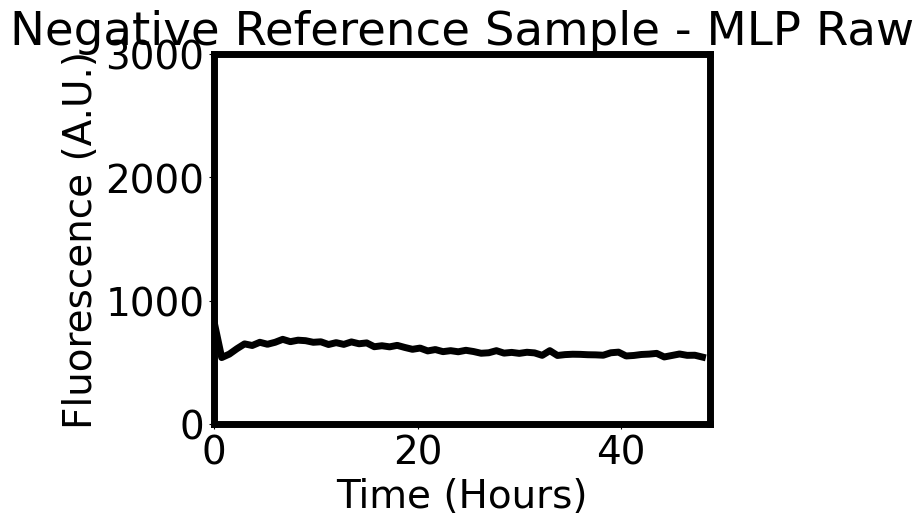

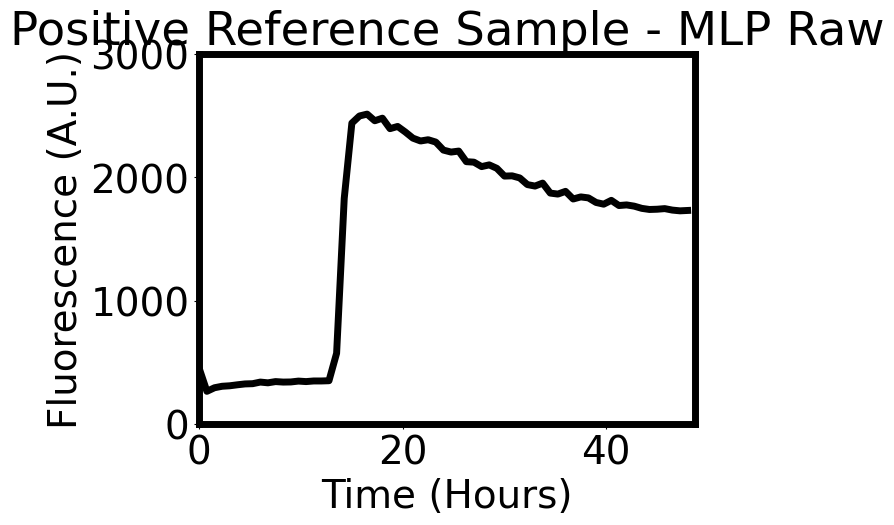

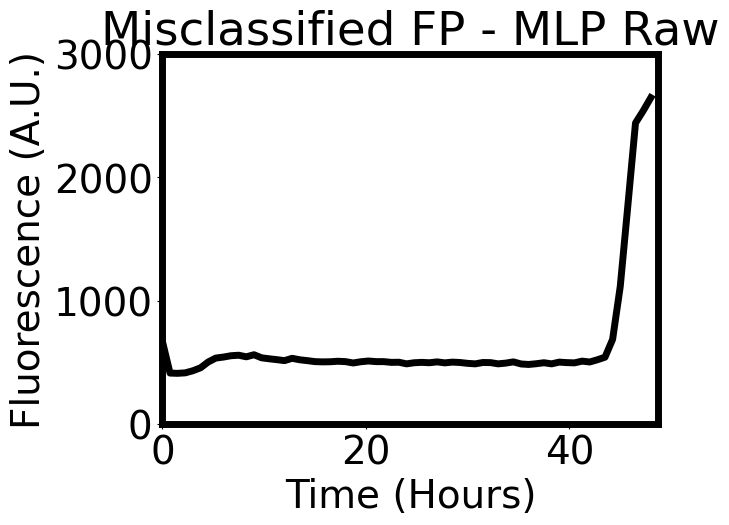

-------- Positive Characteristics for Reference --------
Time To Threshold:
	Min: 4.5, Average: 24.097911200807264, Max: 48.0
RAF:
	Min: 0.020833333, Average: 0.049054801466195765, Max: 0.222222222
MPR:
	Min: 1.241918665, Average: 11.743839485905147, Max: 54.23108384
MS:
	Min: 61.5, Average: 856.7055163084763, Max: 4282.833333
51/51 [==============================] - 0s 2ms/step


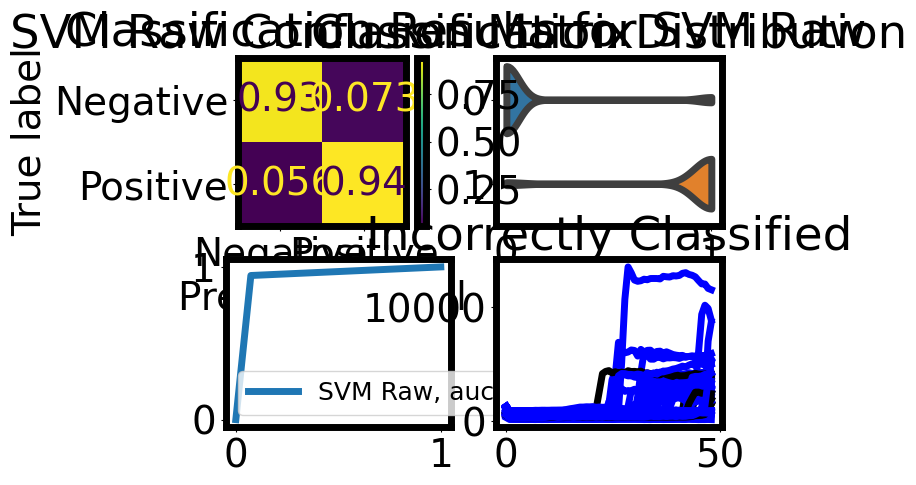

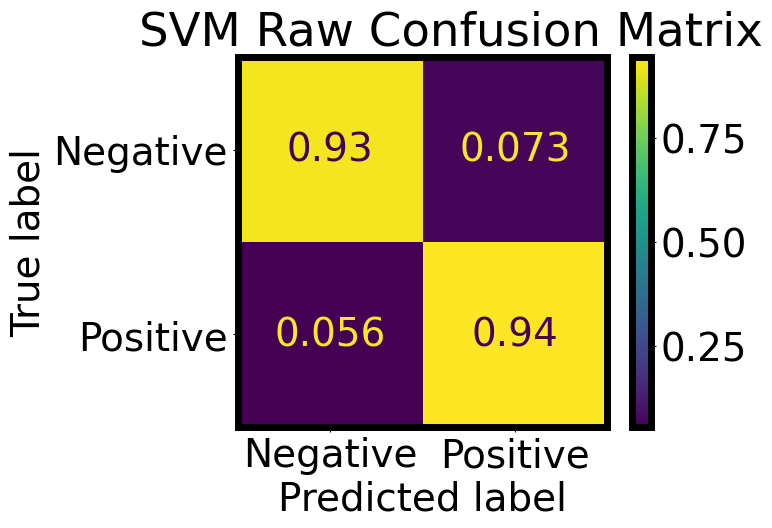

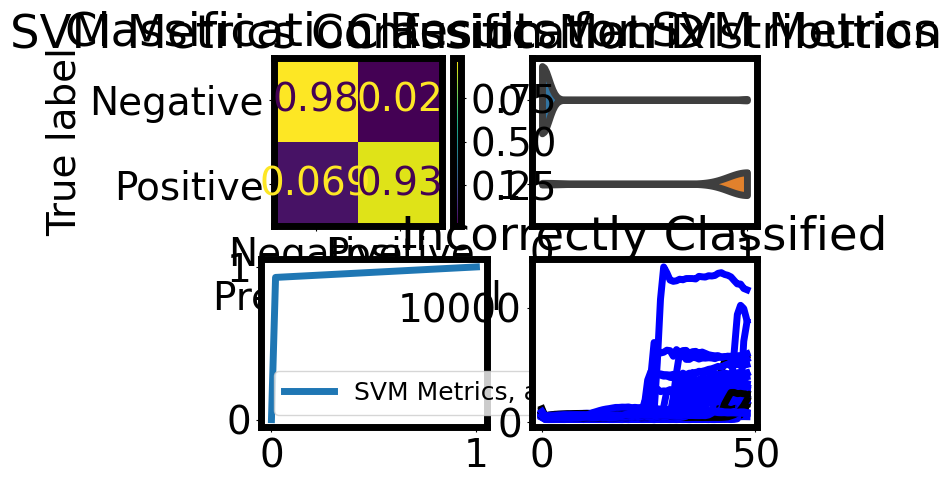

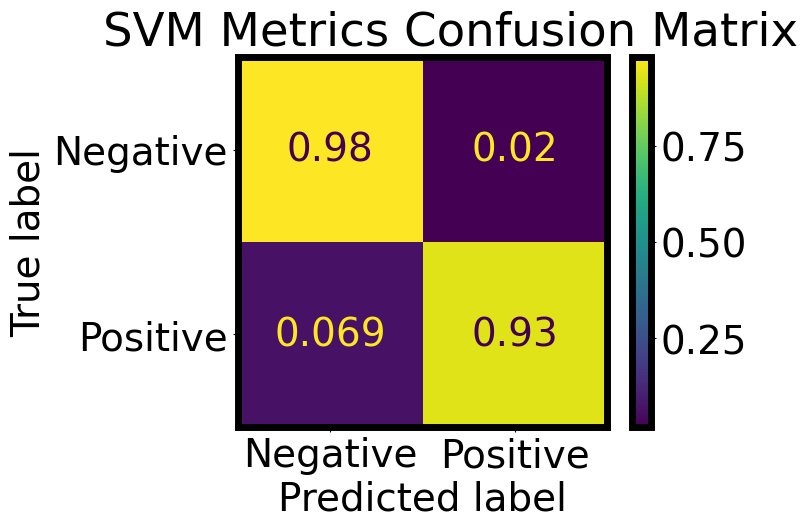

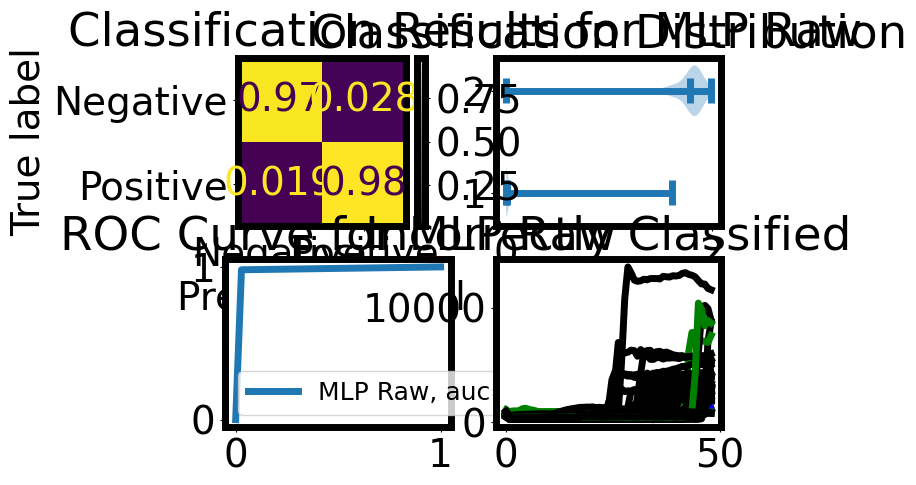

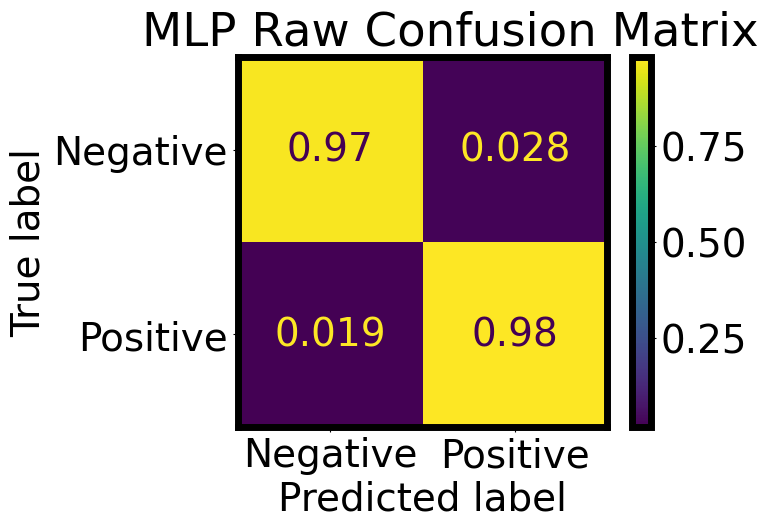

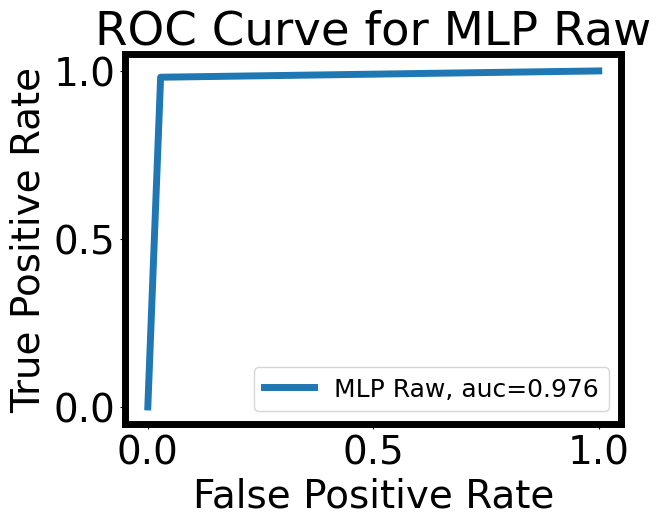

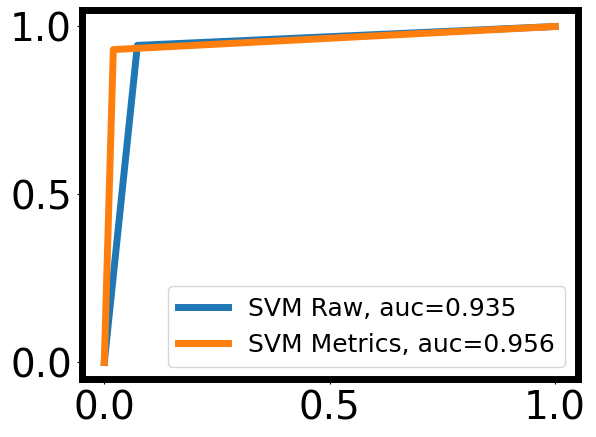

In [8]:
### Get Supervised Scores and Plots
qsIF.get_model_scores(tags = ['Supervised'])
qsIF.evaluate_fp_performance(tags=['Supervised'])
qsIF.get_model_plots(tags=['Supervised'])

### Ambiguous Sample Evaluation
19 of the samples in the original dataset had labels with disagreement between standard metrics-based analysis of the RT-QuIC samples and human annotation. These samples were evaluated separately by the models to compare performance with the human annotation and evaluate the models in a scenario where machine learning represents an important enhancement to current RT-QuIC analysis processes. 

In [9]:
### Test on G Wells
qsIF = qsIF = QuICSeedIF.QuICSeedIF()
qsIF.import_dataset(data_dir='./Data/GrinderGWells')
qsIF.get_dataset_statistics()

qsIF.add_model(KMeansModel.KMeansModel(n_clusters = 3,
                                          file_path= './SavedModels/Analysis/', model_name='kmeans'
                                          ), model_name='KMeans Metrics', data_type='analysis', tag='Unsupervised')

qsIF.add_model(SVM.SVM(
    file_path='./SavedModels/Raw/', model_name='svm'
    ), model_name = 'SVM Raw', data_type = 'raw', tag = 'Supervised')

qsIF.add_model(SVM.SVM(
    file_path='./SavedModels/Analysis/', model_name='svm'
    ), model_name = 'SVM Metrics', data_type = 'analysis', tag = 'Supervised')

qsIF.add_model(MLP.MLP(NDIM = qsIF.get_num_timesteps_raw(), 
                          file_path='./SavedModels/Raw/', model_name='mlp'
                          ), model_name = 'MLP Raw', data_type = 'raw', tag='Supervised')

qsIF.separate_train_test(tags=['Supervised', 'Unsupervised'], train_type=3, file_loc='./TrainTest/GWells')

### Get Supervised Scores and Plots
qsIF.get_model_scores(tags = ['Supervised', 'Unsupervised'])

pred_km, sample_list_km = qsIF.evaluate_replicate_performance(model='KMeans Metrics')
pred_svm_r, sample_list_svmr = qsIF.evaluate_replicate_performance(model='SVM Raw')
pred_svm_m, sample_list_svmm = qsIF.evaluate_replicate_performance(model='SVM Metrics')
pred_mlp, sample_list_mlp = qsIF.evaluate_replicate_performance(model='MLP Raw')

import pandas as pd
human = np.array(pd.read_csv('./Data/GrinderGWells/Human_Annotation.csv'))

print('Model Sample Predictions:')
print('\n{:20s} {:20s} {:20s} {:20s} {:20s}'.format('Sample:', 'KMeans Metrics:', 'SVM Raw:', 'SVM Metrics:', 'MLP Raw:'))
agreement = [0, 0, 0, 0]
for i in range(len(pred_km)):
    if sample_list_km[i] != sample_list_mlp[i] or sample_list_mlp[i] != sample_list_svmm[i] or sample_list_svmm[i] != sample_list_svmr[i]:
        raise Exception('Sample order does not agree!')
    print('{:20s} {:20s} {:20s} {:20s} {:20s}'.format(sample_list_km[i], pred_km[i], pred_svm_r[i], pred_svm_m[i], pred_mlp[i]))
    agreement[0] = 8 - abs(human[int(i/2), i%2] - int(pred_km[i][0])) + agreement[0]
    agreement[1] = 8 - abs(human[int(i/2), i%2] - int(pred_svm_r[i][0])) + agreement[1]
    agreement[2] = 8 - abs(human[int(i/2), i%2] - int(pred_svm_m[i][0])) + agreement[2]
    agreement[3] = 8 - abs(human[int(i/2), i%2] - int(pred_mlp[i][0])) + agreement[3]

print(agreement)
    


Loading Data from ./Data/GrinderGWells
---- Dataset Label Distribution ----
Negative Samples: 208
False Positive Samples: 0
Positive Samples: 96

---- Well Content Distribution: ----
Data Wells: 304
Control Wells: 0

KMeans Model Loaded:
<class 'sklearn.cluster._kmeans.KMeans'>

SVM Model Loaded:
<class 'sklearn.svm._classes.SVC'>

SVM Model Loaded:
<class 'sklearn.svm._classes.SVC'>
\MLP Model Loaded:
<class 'keras.engine.functional.Functional'>
SVM Raw:
              precision    recall  f1-score   support

         neg       0.84      1.00      0.91       208
         pos       0.98      0.58      0.73        96

    accuracy                           0.87       304
   macro avg       0.91      0.79      0.82       304
weighted avg       0.88      0.87      0.85       304

SVM Metrics:
              precision    recall  f1-score   support

         neg       1.00      1.00      1.00       208
         pos       1.00      1.00      1.00        96

    accuracy                        

## Validation Data Analysis
The validation analysis evaluates the saved models on a separately generated, completely independent dataset from the original, removing nearly all possibility of cross-contamination between the training and testing datasets. This independent analysis provides the best test for generalizability of each model as performance on this data more directly translates to performance on arbitrary RT-QuIC data.

Loading Data from ./Data/ValidationData


---- Dataset Label Distribution ----
Negative Samples: 122
False Positive Samples: 15
Positive Samples: 31

---- Well Content Distribution: ----
Data Wells: 156
Control Wells: 12

KMeans Model Loaded:
<class 'sklearn.cluster._kmeans.KMeans'>

KMeans Model Loaded:
<class 'sklearn.cluster._kmeans.KMeans'>

SVM Model Loaded:
<class 'sklearn.svm._classes.SVC'>

SVM Model Loaded:
<class 'sklearn.svm._classes.SVC'>
\MLP Model Loaded:
<class 'keras.engine.functional.Functional'>
-------- Results on False Positives for KMeans Raw --------
Accuracy on False Positives: 0.2
False Positives Account for 8.70% of total misclassifications.
Misclassified FP Characteristics:
Average Time to Threshold: 45.840833333333336
Average RAF: 0.022555467
Average MPR: 13.547375156416669
Average MS: 12383.555556166664
Correctly Classified FP Characteristics:
Average Time to Threshold: 37.449999999999996
Average RAF: 0.027024231333333332
Average MPR: 33.07124232
Average MS: 35914.72222333334
KMeans Raw:
           

No negative values correctly classified.


6/6 [==============================] - 0s 2ms/step


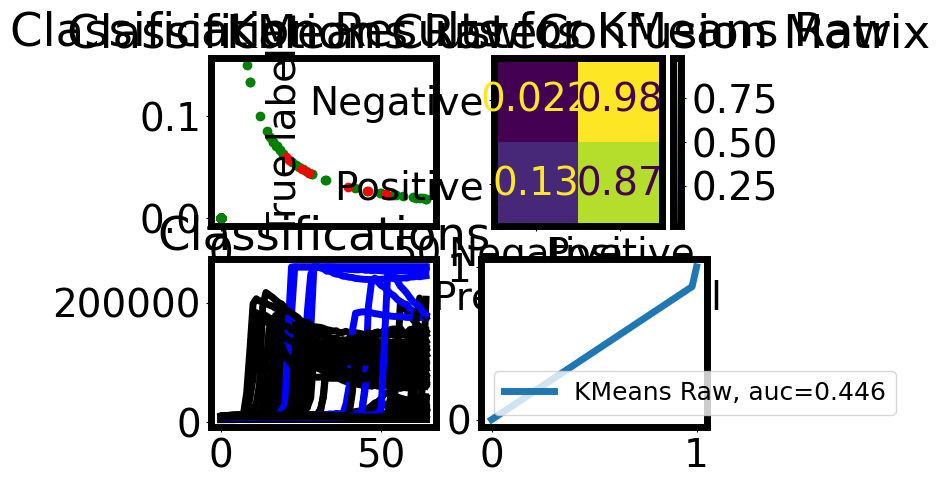

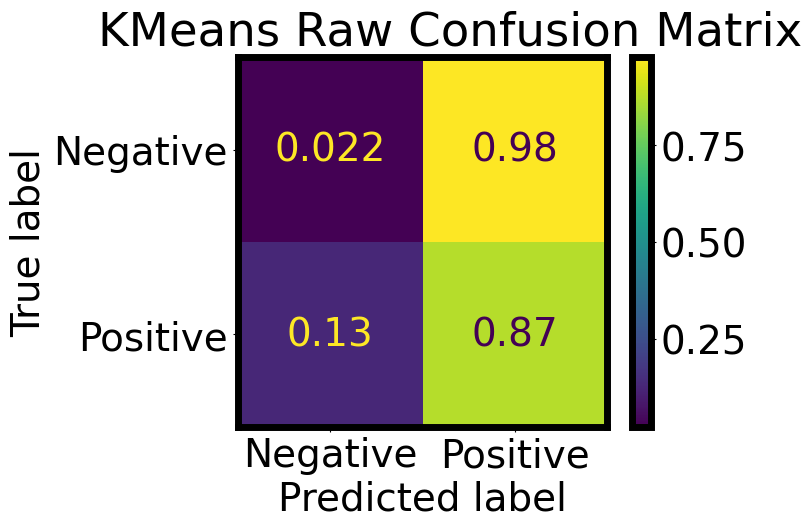

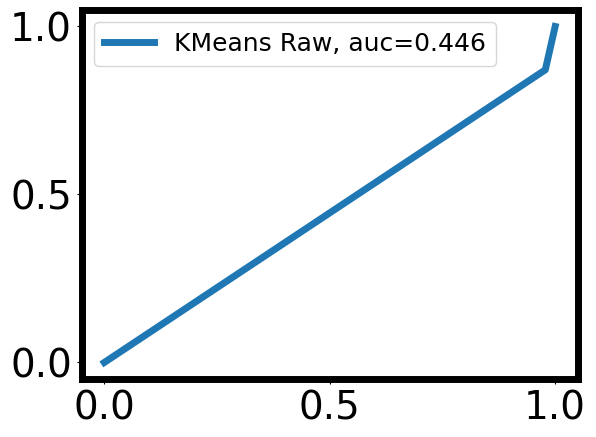

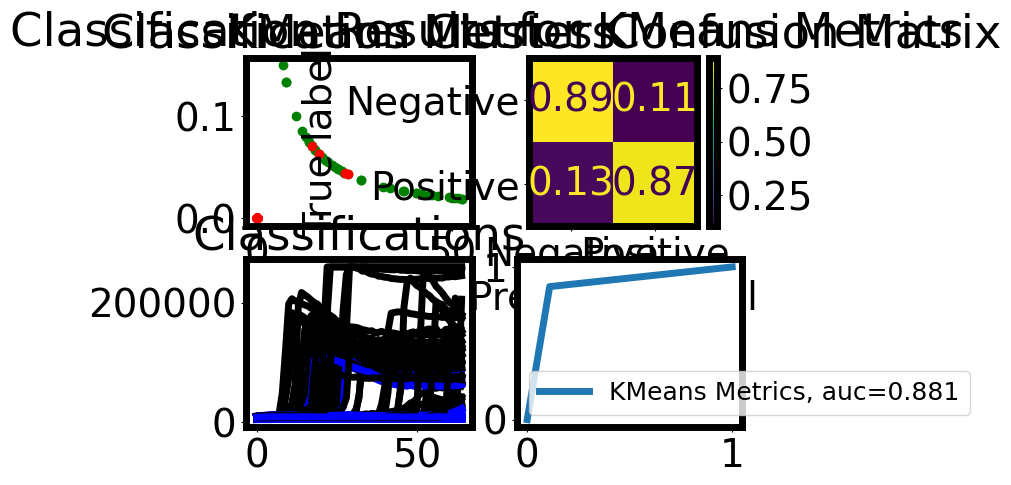

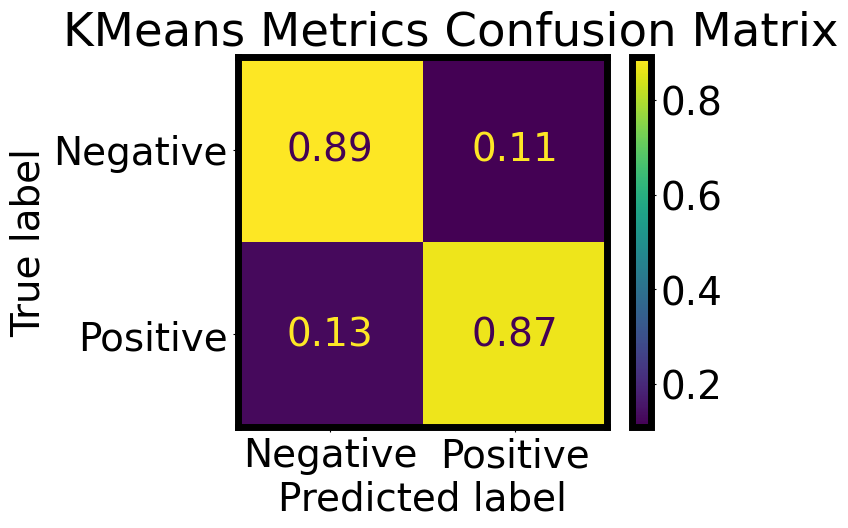

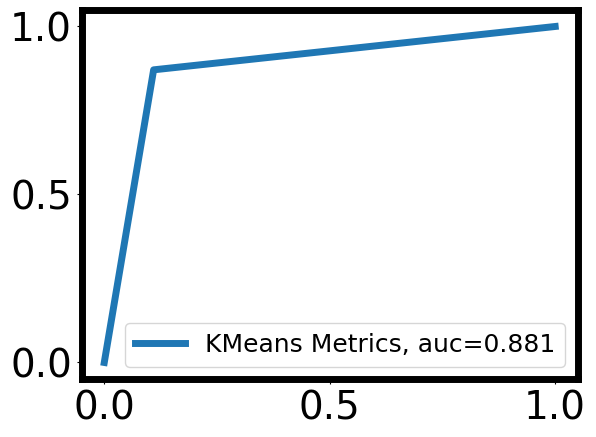

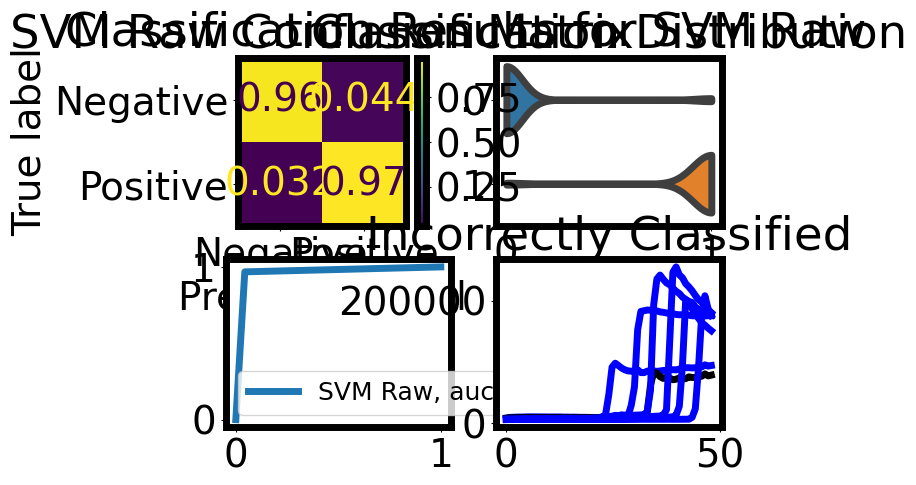

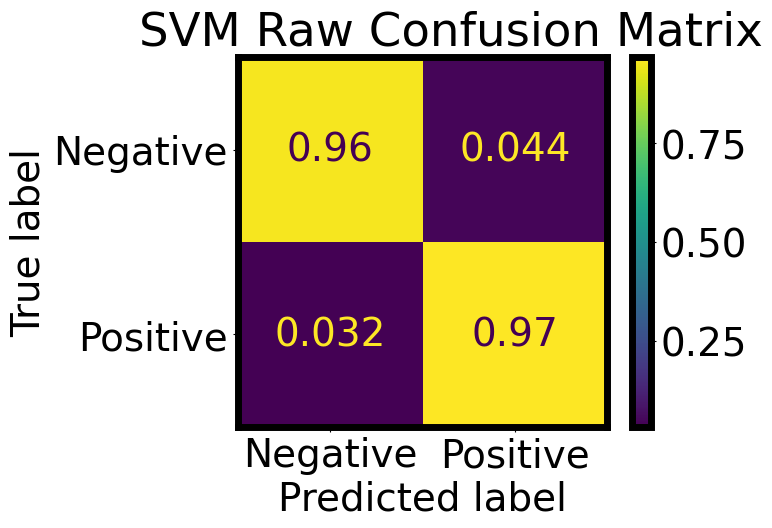

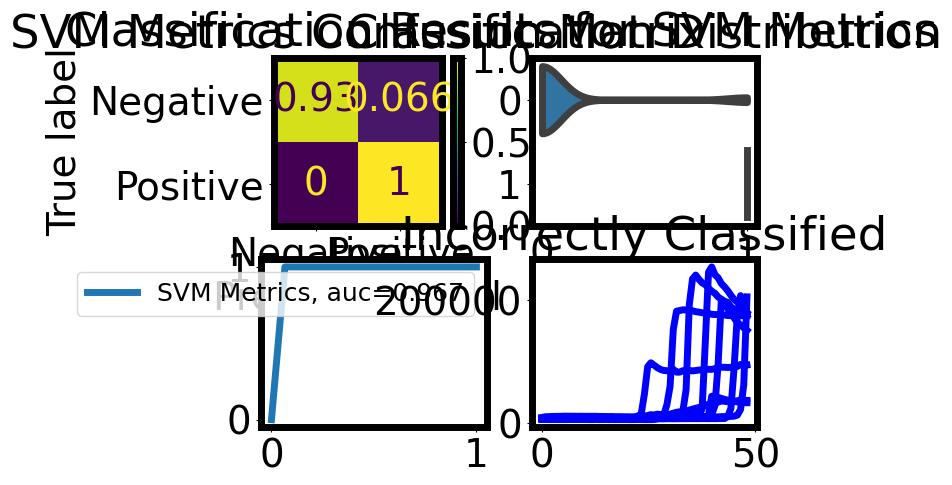

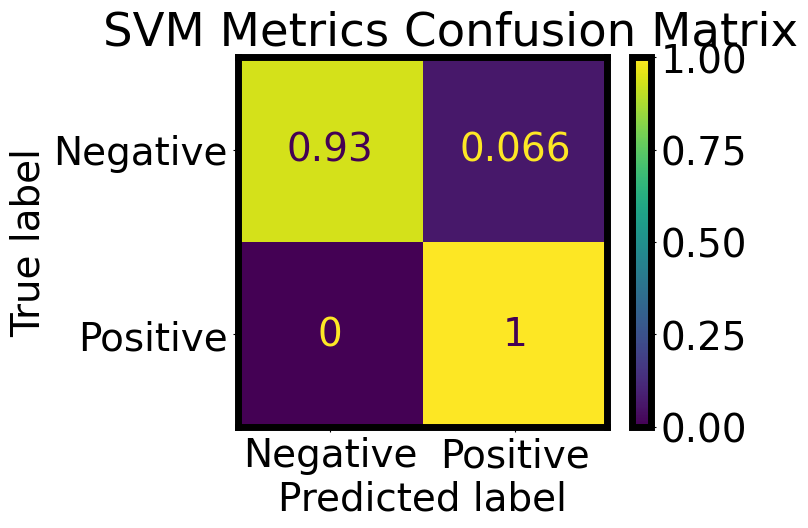

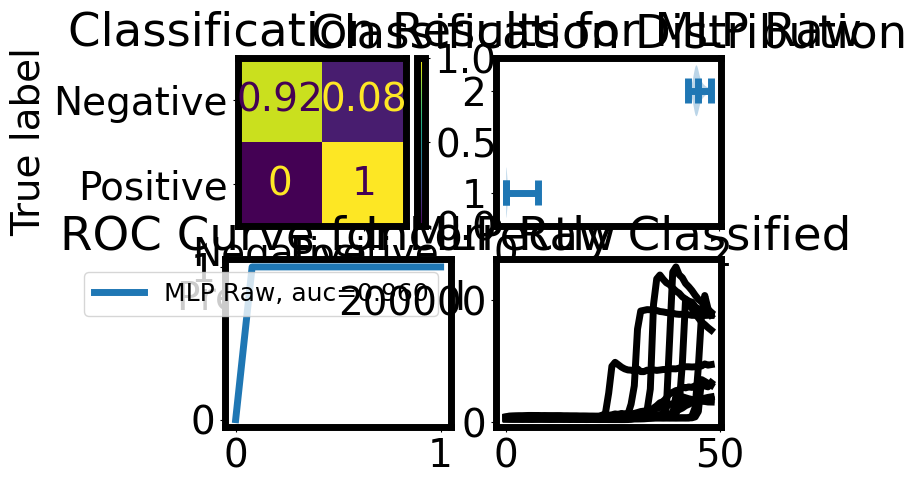

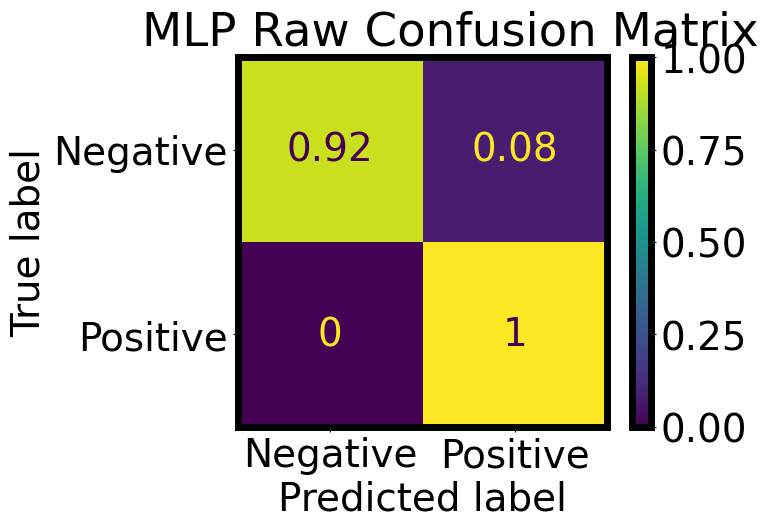

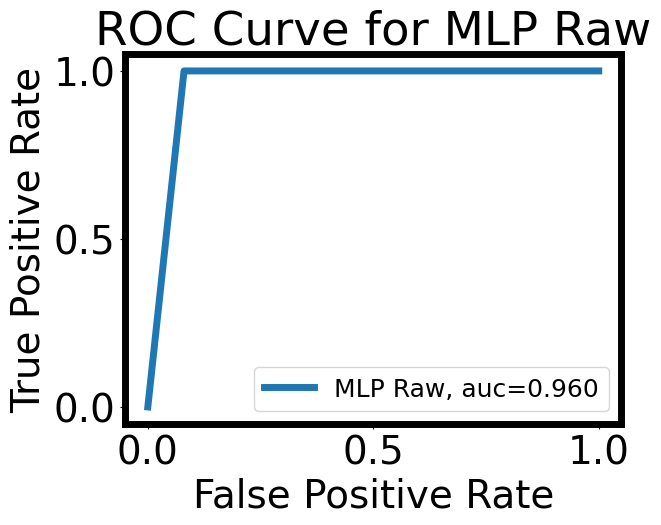

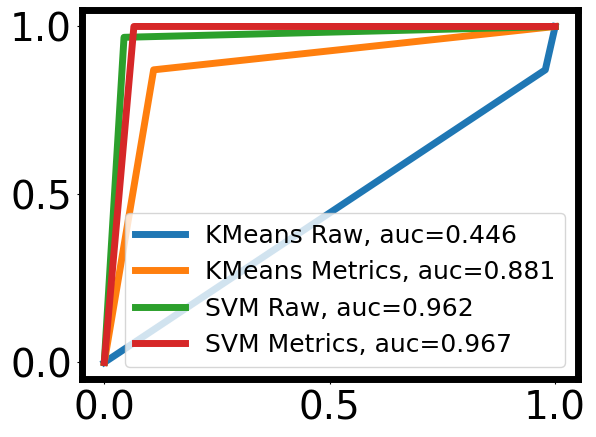

In [10]:
### Test on Unrelated Data
qsIF = qsIF = QuICSeedIF.QuICSeedIF()
qsIF.import_dataset(data_dir='./Data/ValidationData')
qsIF.get_dataset_statistics()

qsIF.add_model(KMeansModel.KMeansModel(n_clusters = 3,
                                          file_path= './SavedModels/Raw/', model_name='kmeans'
                                          ), model_name='KMeans Raw', data_type='raw', tag='Unsupervised')
qsIF.add_model(KMeansModel.KMeansModel(n_clusters = 3,
                                          file_path= './SavedModels/Analysis/', model_name='kmeans'
                                          ), model_name='KMeans Metrics', data_type='analysis', tag='Unsupervised')

qsIF.add_model(SVM.SVM(
    file_path='./SavedModels/Raw/', model_name='svm'
    ), model_name = 'SVM Raw', data_type = 'raw', tag = 'Supervised')

qsIF.add_model(SVM.SVM(
    file_path='./SavedModels/Analysis/', model_name='svm'
    ), model_name = 'SVM Metrics', data_type = 'analysis', tag = 'Supervised')

qsIF.add_model(MLP.MLP(NDIM = qsIF.get_num_timesteps_raw(), 
                          file_path='./SavedModels/Raw/', model_name='mlp'
                          ), model_name = 'MLP Raw', data_type = 'raw', tag='Supervised')

qsIF.separate_train_test(tags=['Supervised', 'Unsupervised'], train_type=3, file_loc='./TrainTest/Val_Data')

### Get Supervised Scores and Plots
qsIF.evaluate_fp_performance(tags=['Unsupervised', 'Supervised'], file_loc='./FiguresVal/')
qsIF.get_model_scores(tags = ['Unsupervised', 'Supervised'])
qsIF.get_model_plots(tags=['Unsupervised', 'Supervised'], file_loc='./FiguresVal/')

## Feature Threshold Analysis
### Selecting Most Important Time Steps

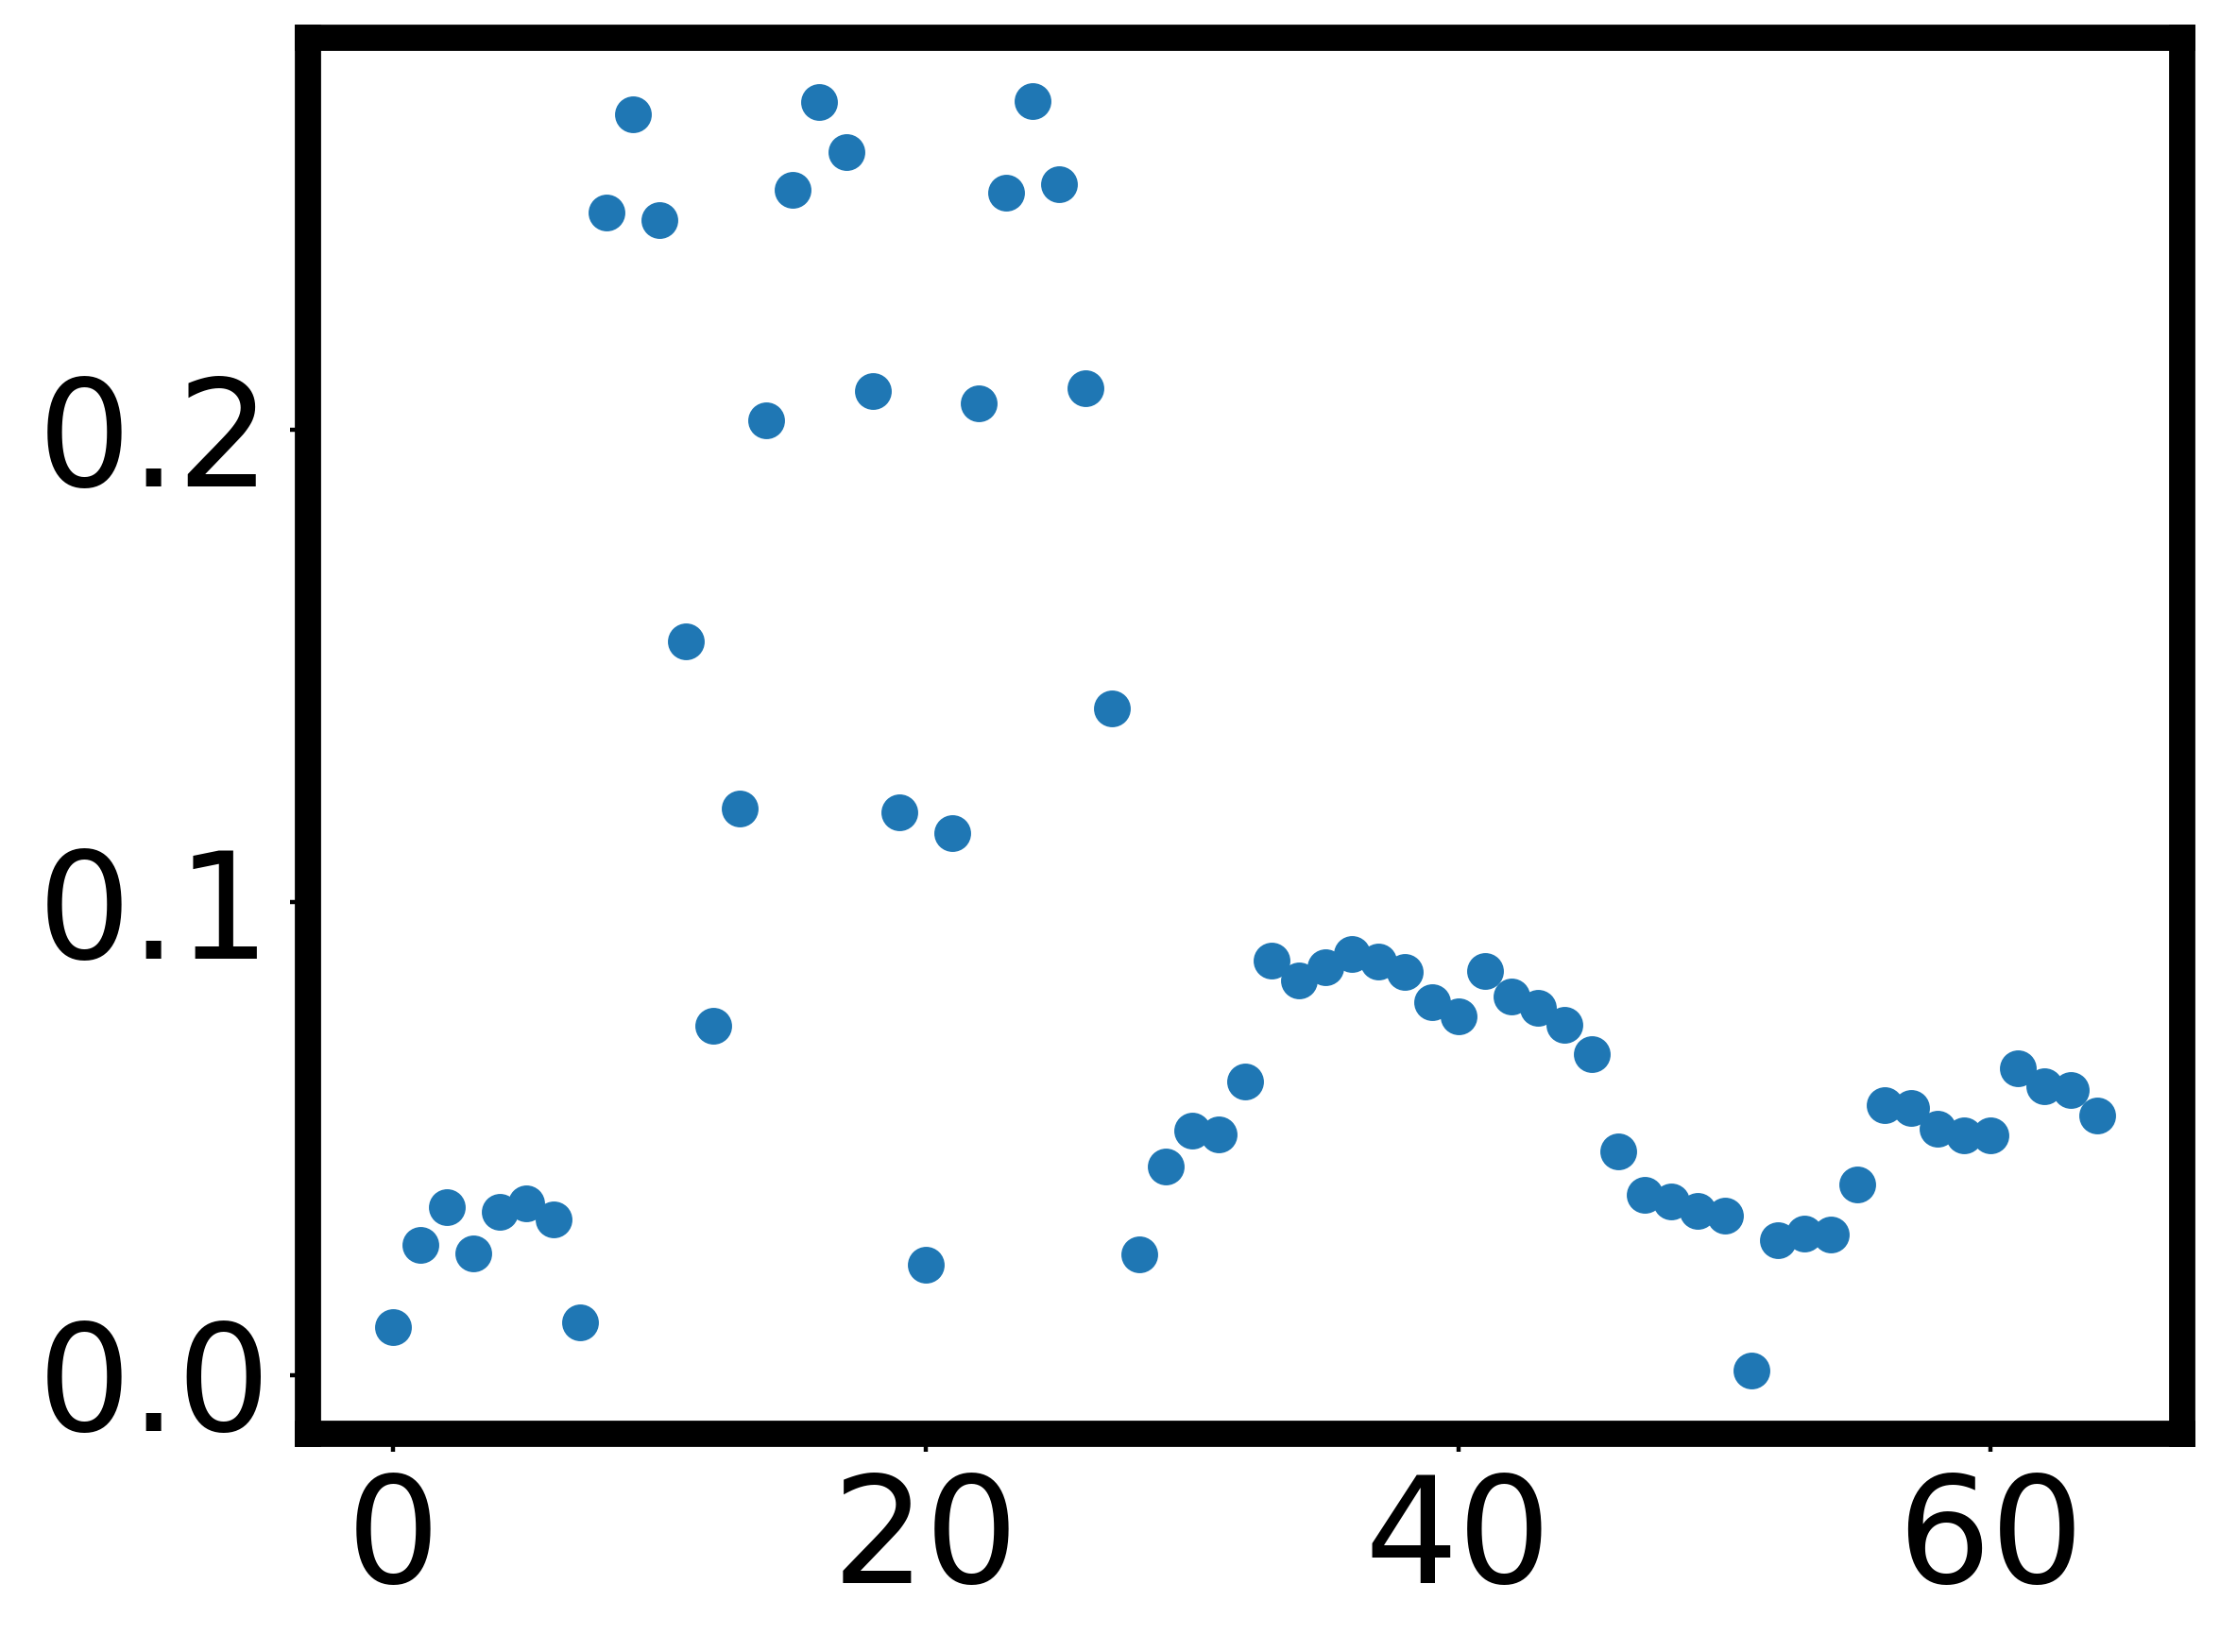

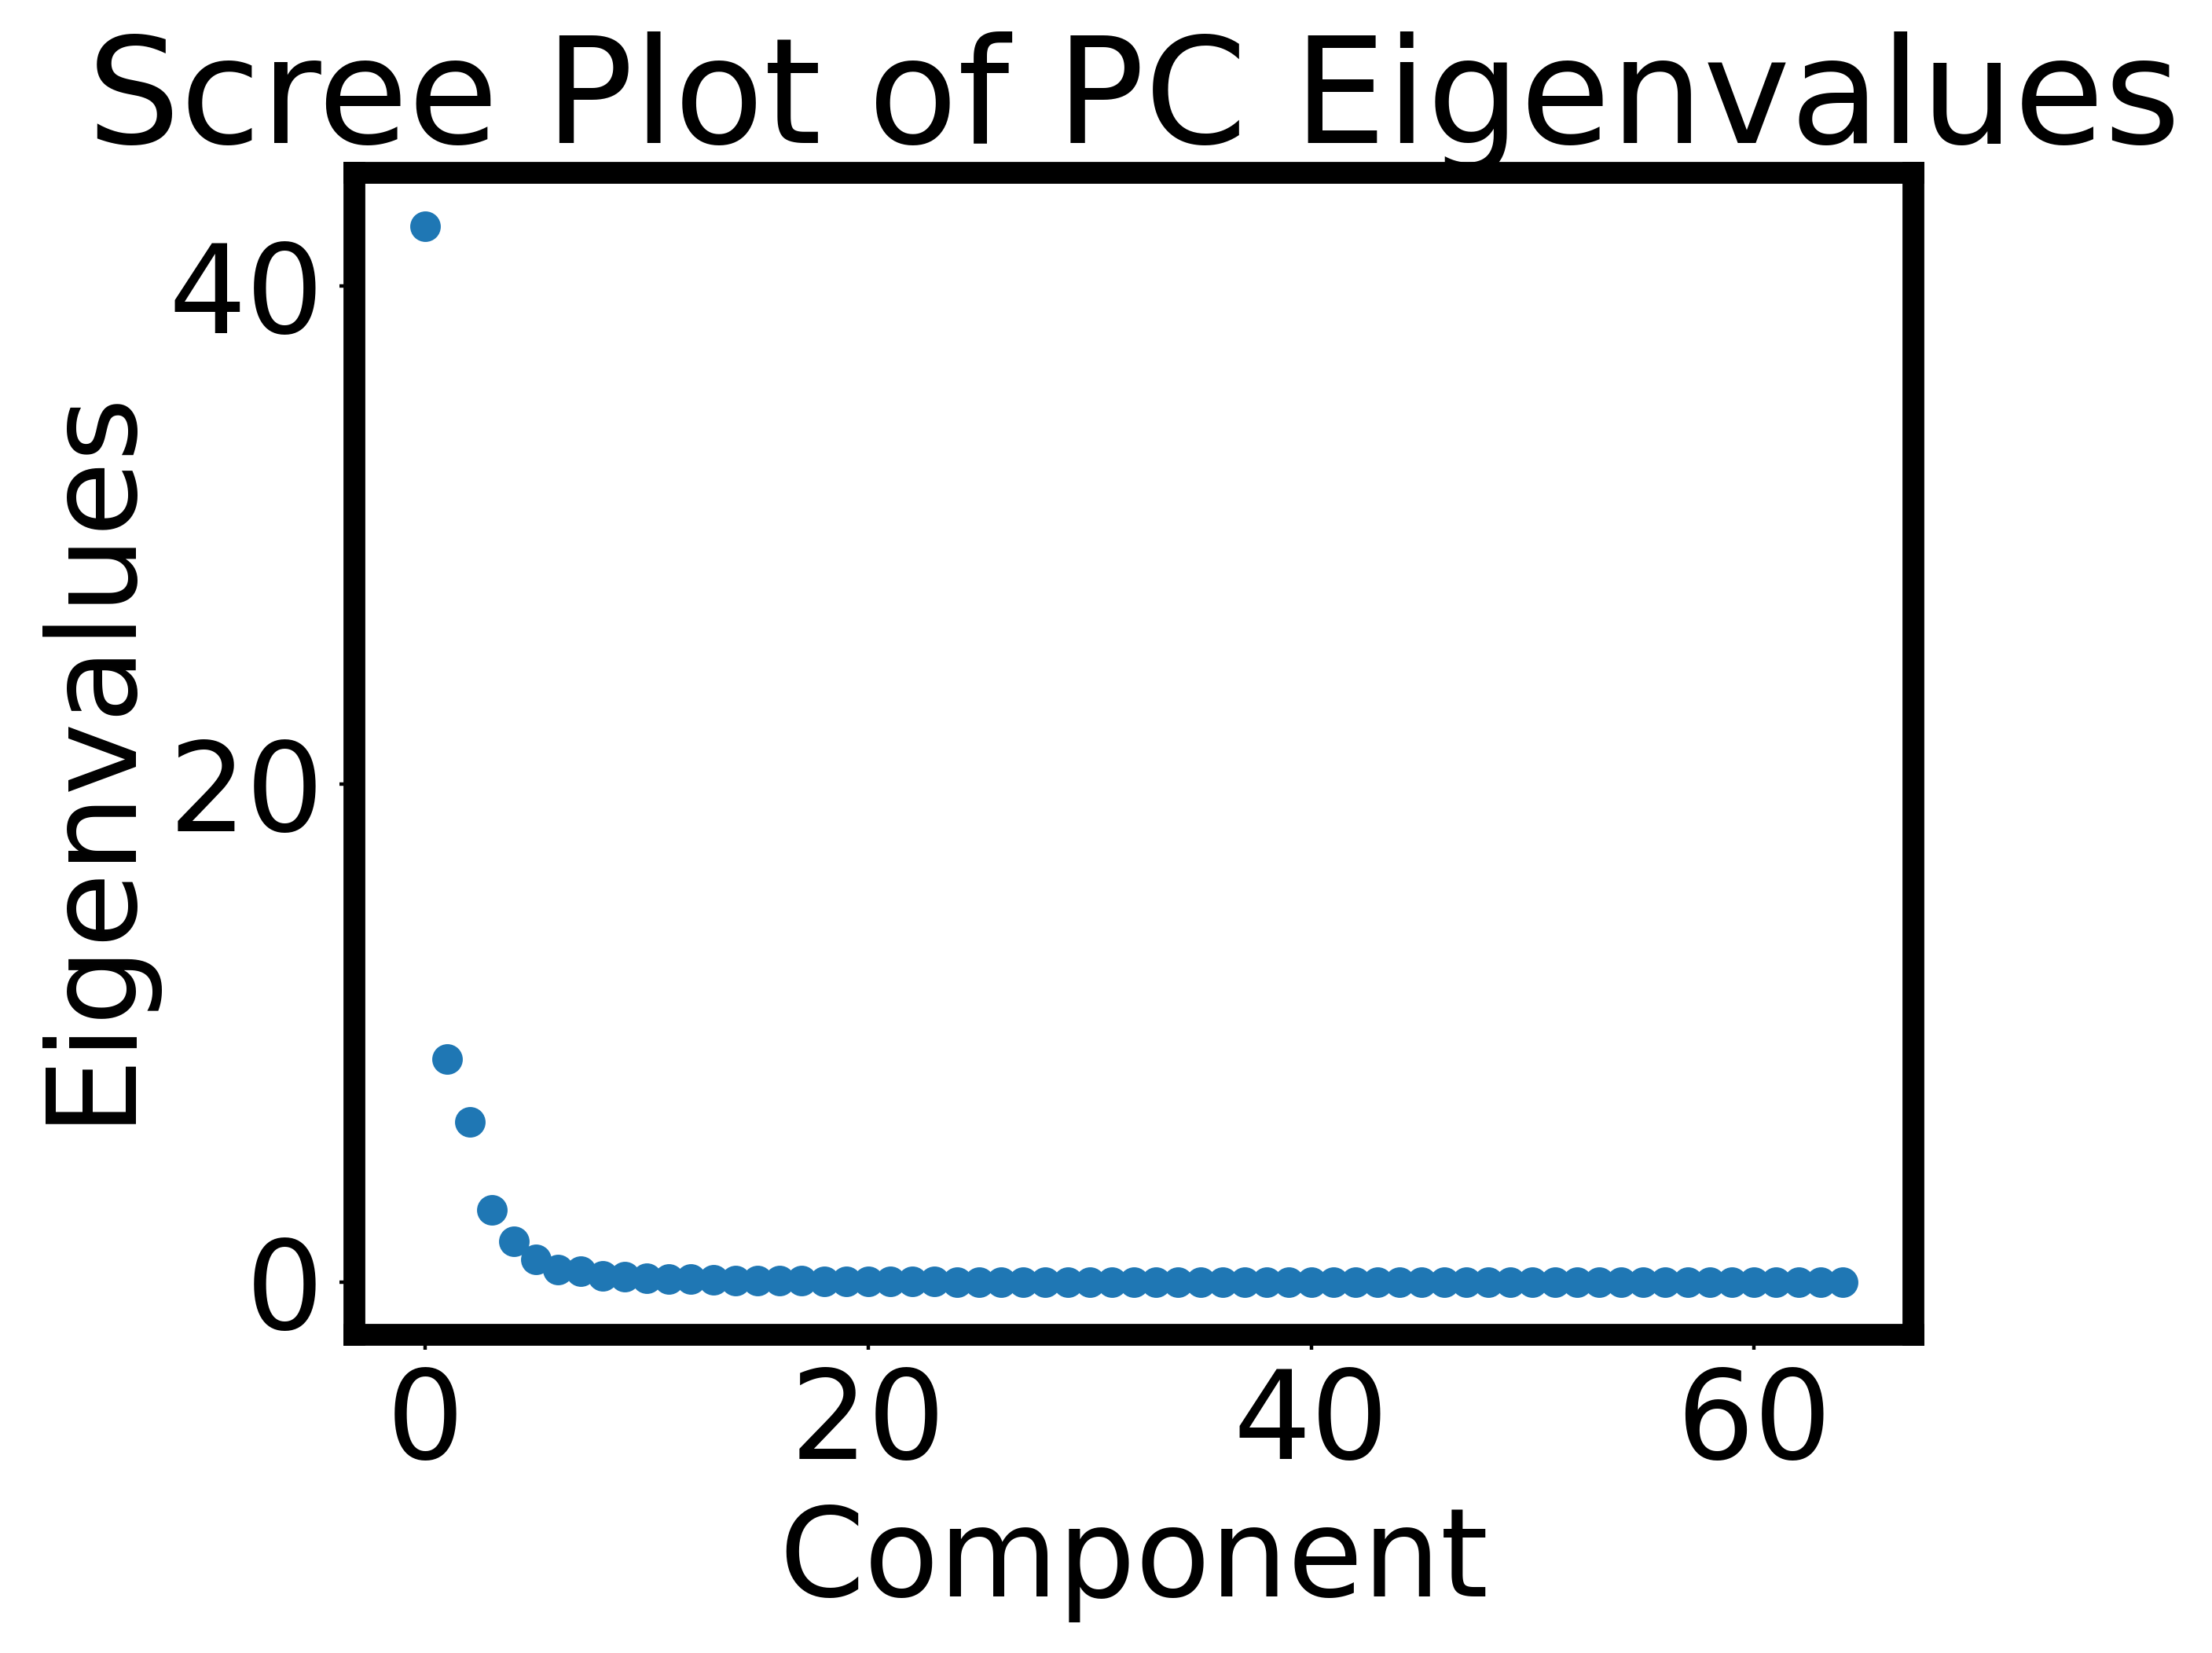

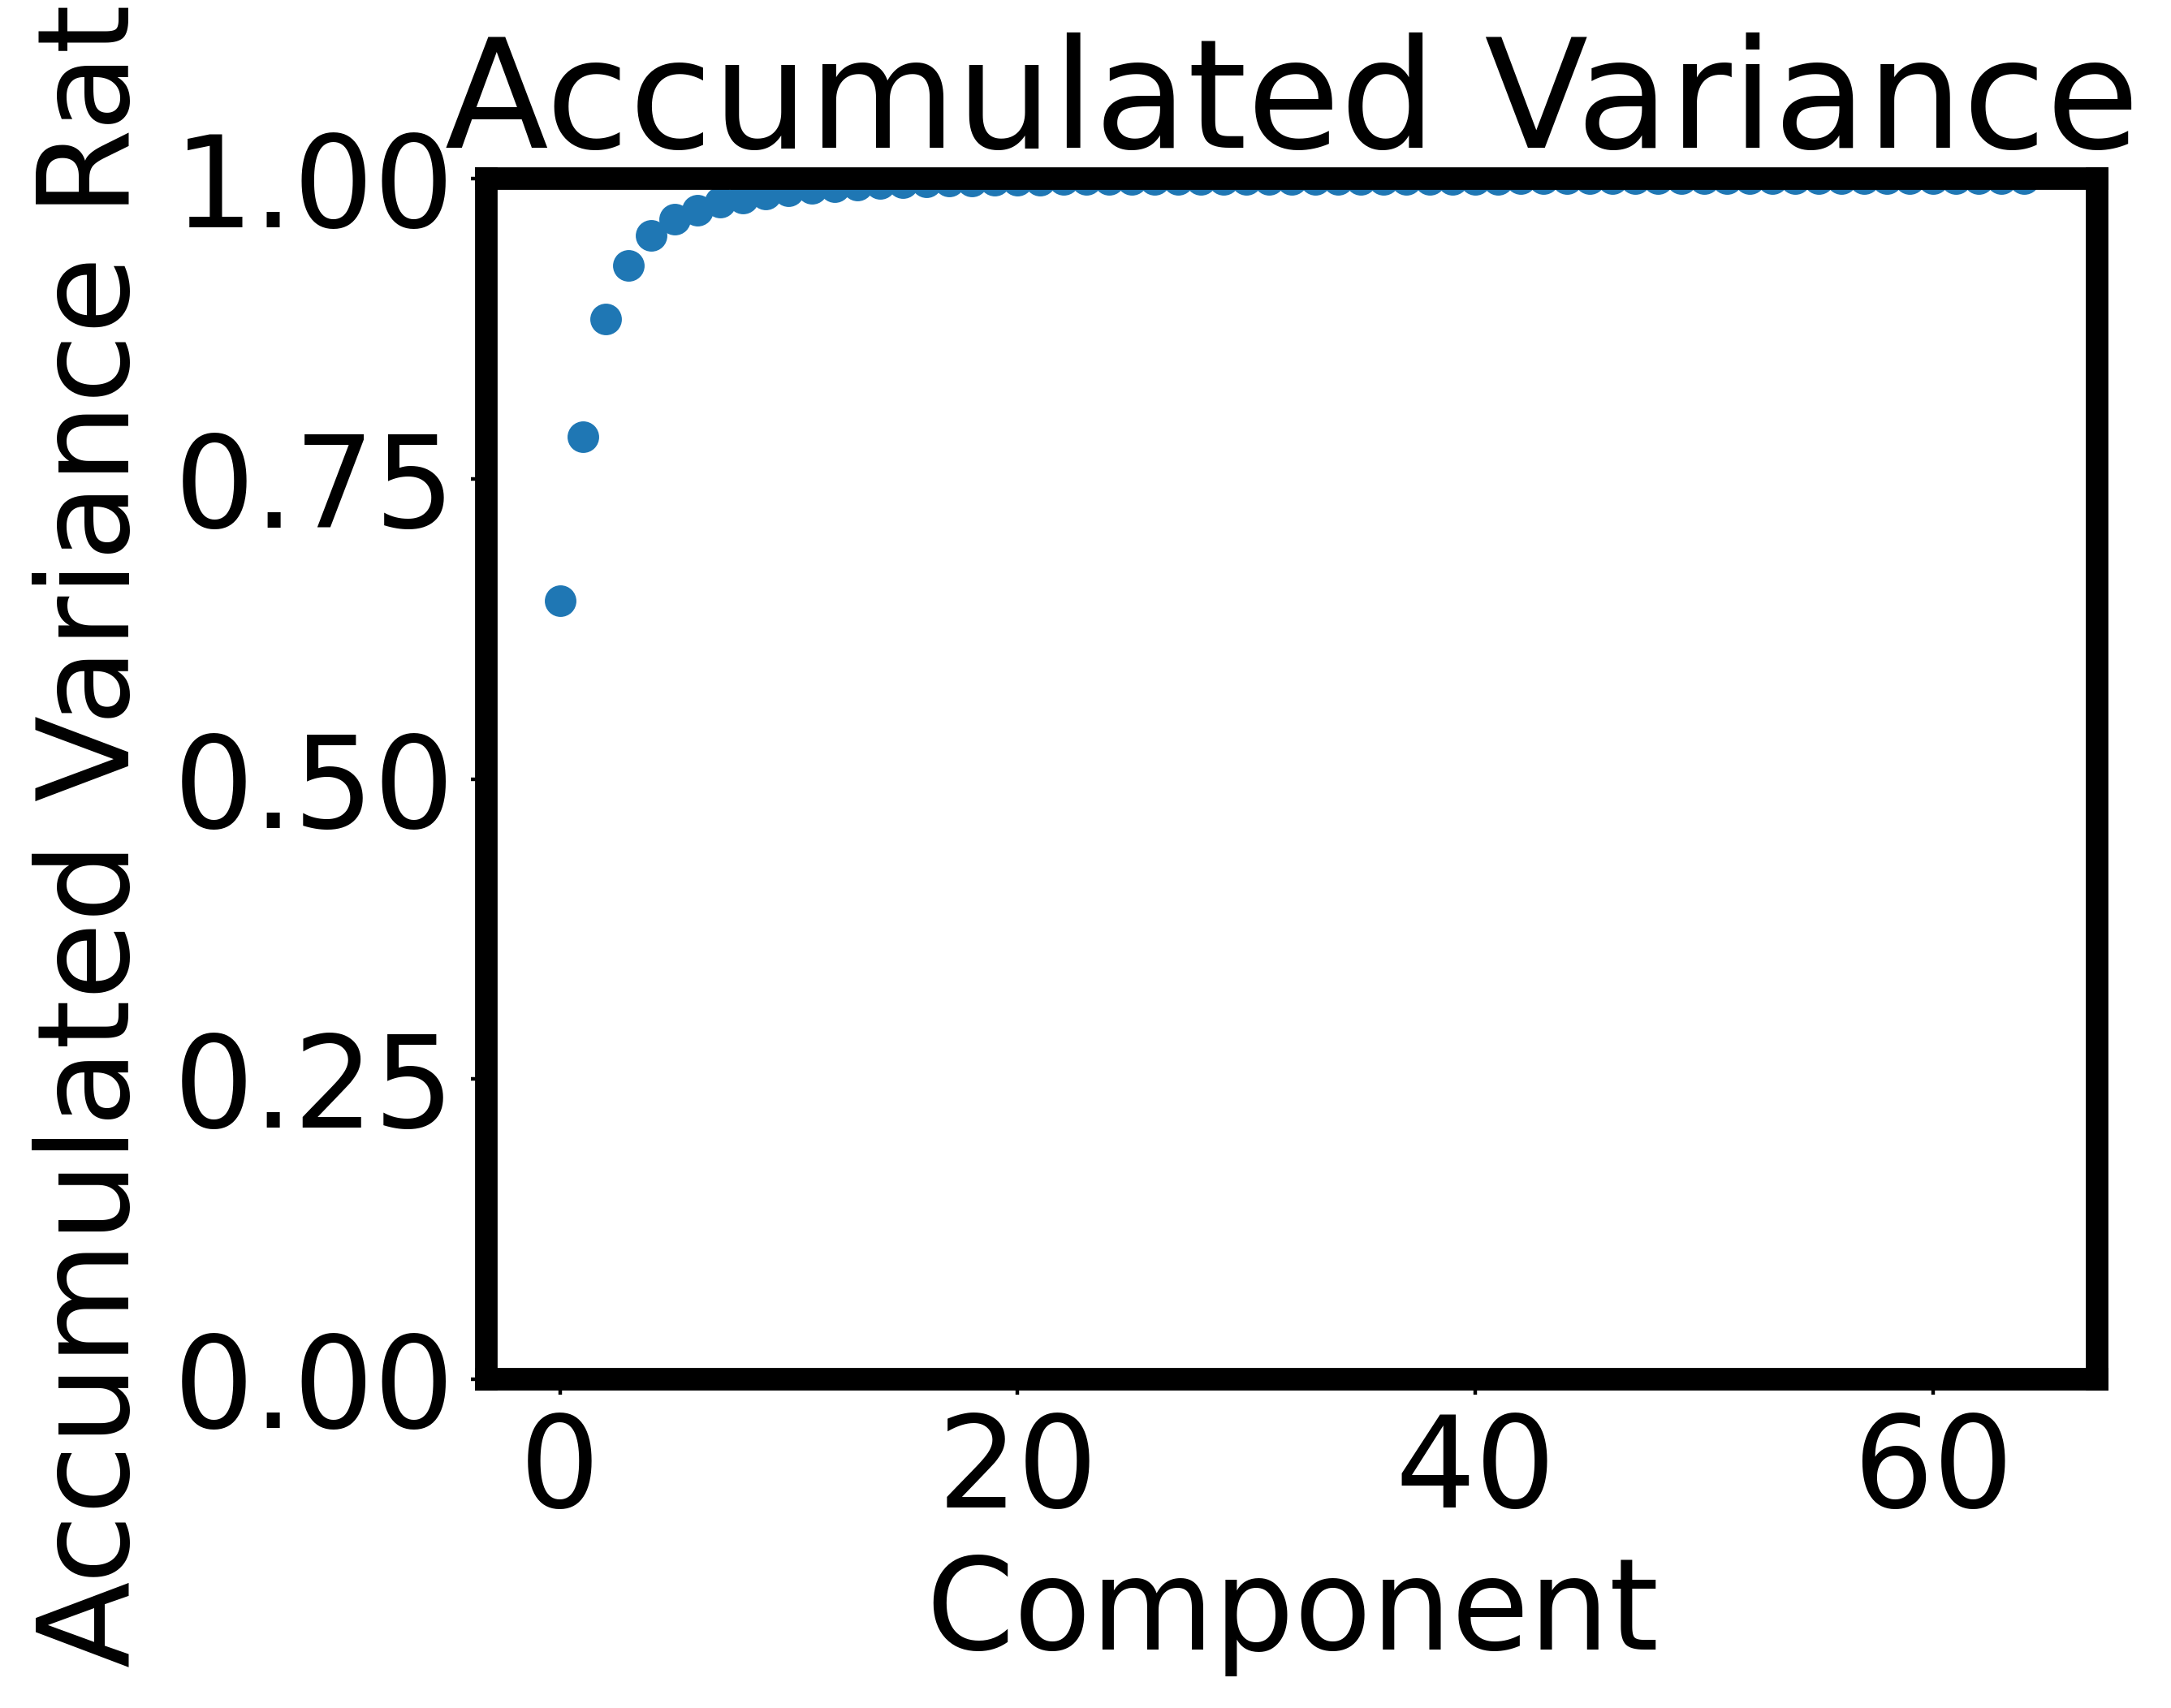

    content_replicate  labels        PC1       PC2
0               pos_1       2   7.960293  2.335533
1               SDS_1       0  -1.840387  2.907508
2               166_1       0  -1.639360  3.317473
3               197_1       2  14.041915  2.184764
4               333_1       0  -3.739660 -1.513061
..                ...     ...        ...       ...
163             269_4       0  -3.060120  0.052036
164             232_4       1   8.094913 -4.850093
165            193_41       0  -3.410647 -0.820058
166             188_4       0  -3.196443 -0.141077
167             118_4       1  -1.473378  1.284273

[168 rows x 4 columns]


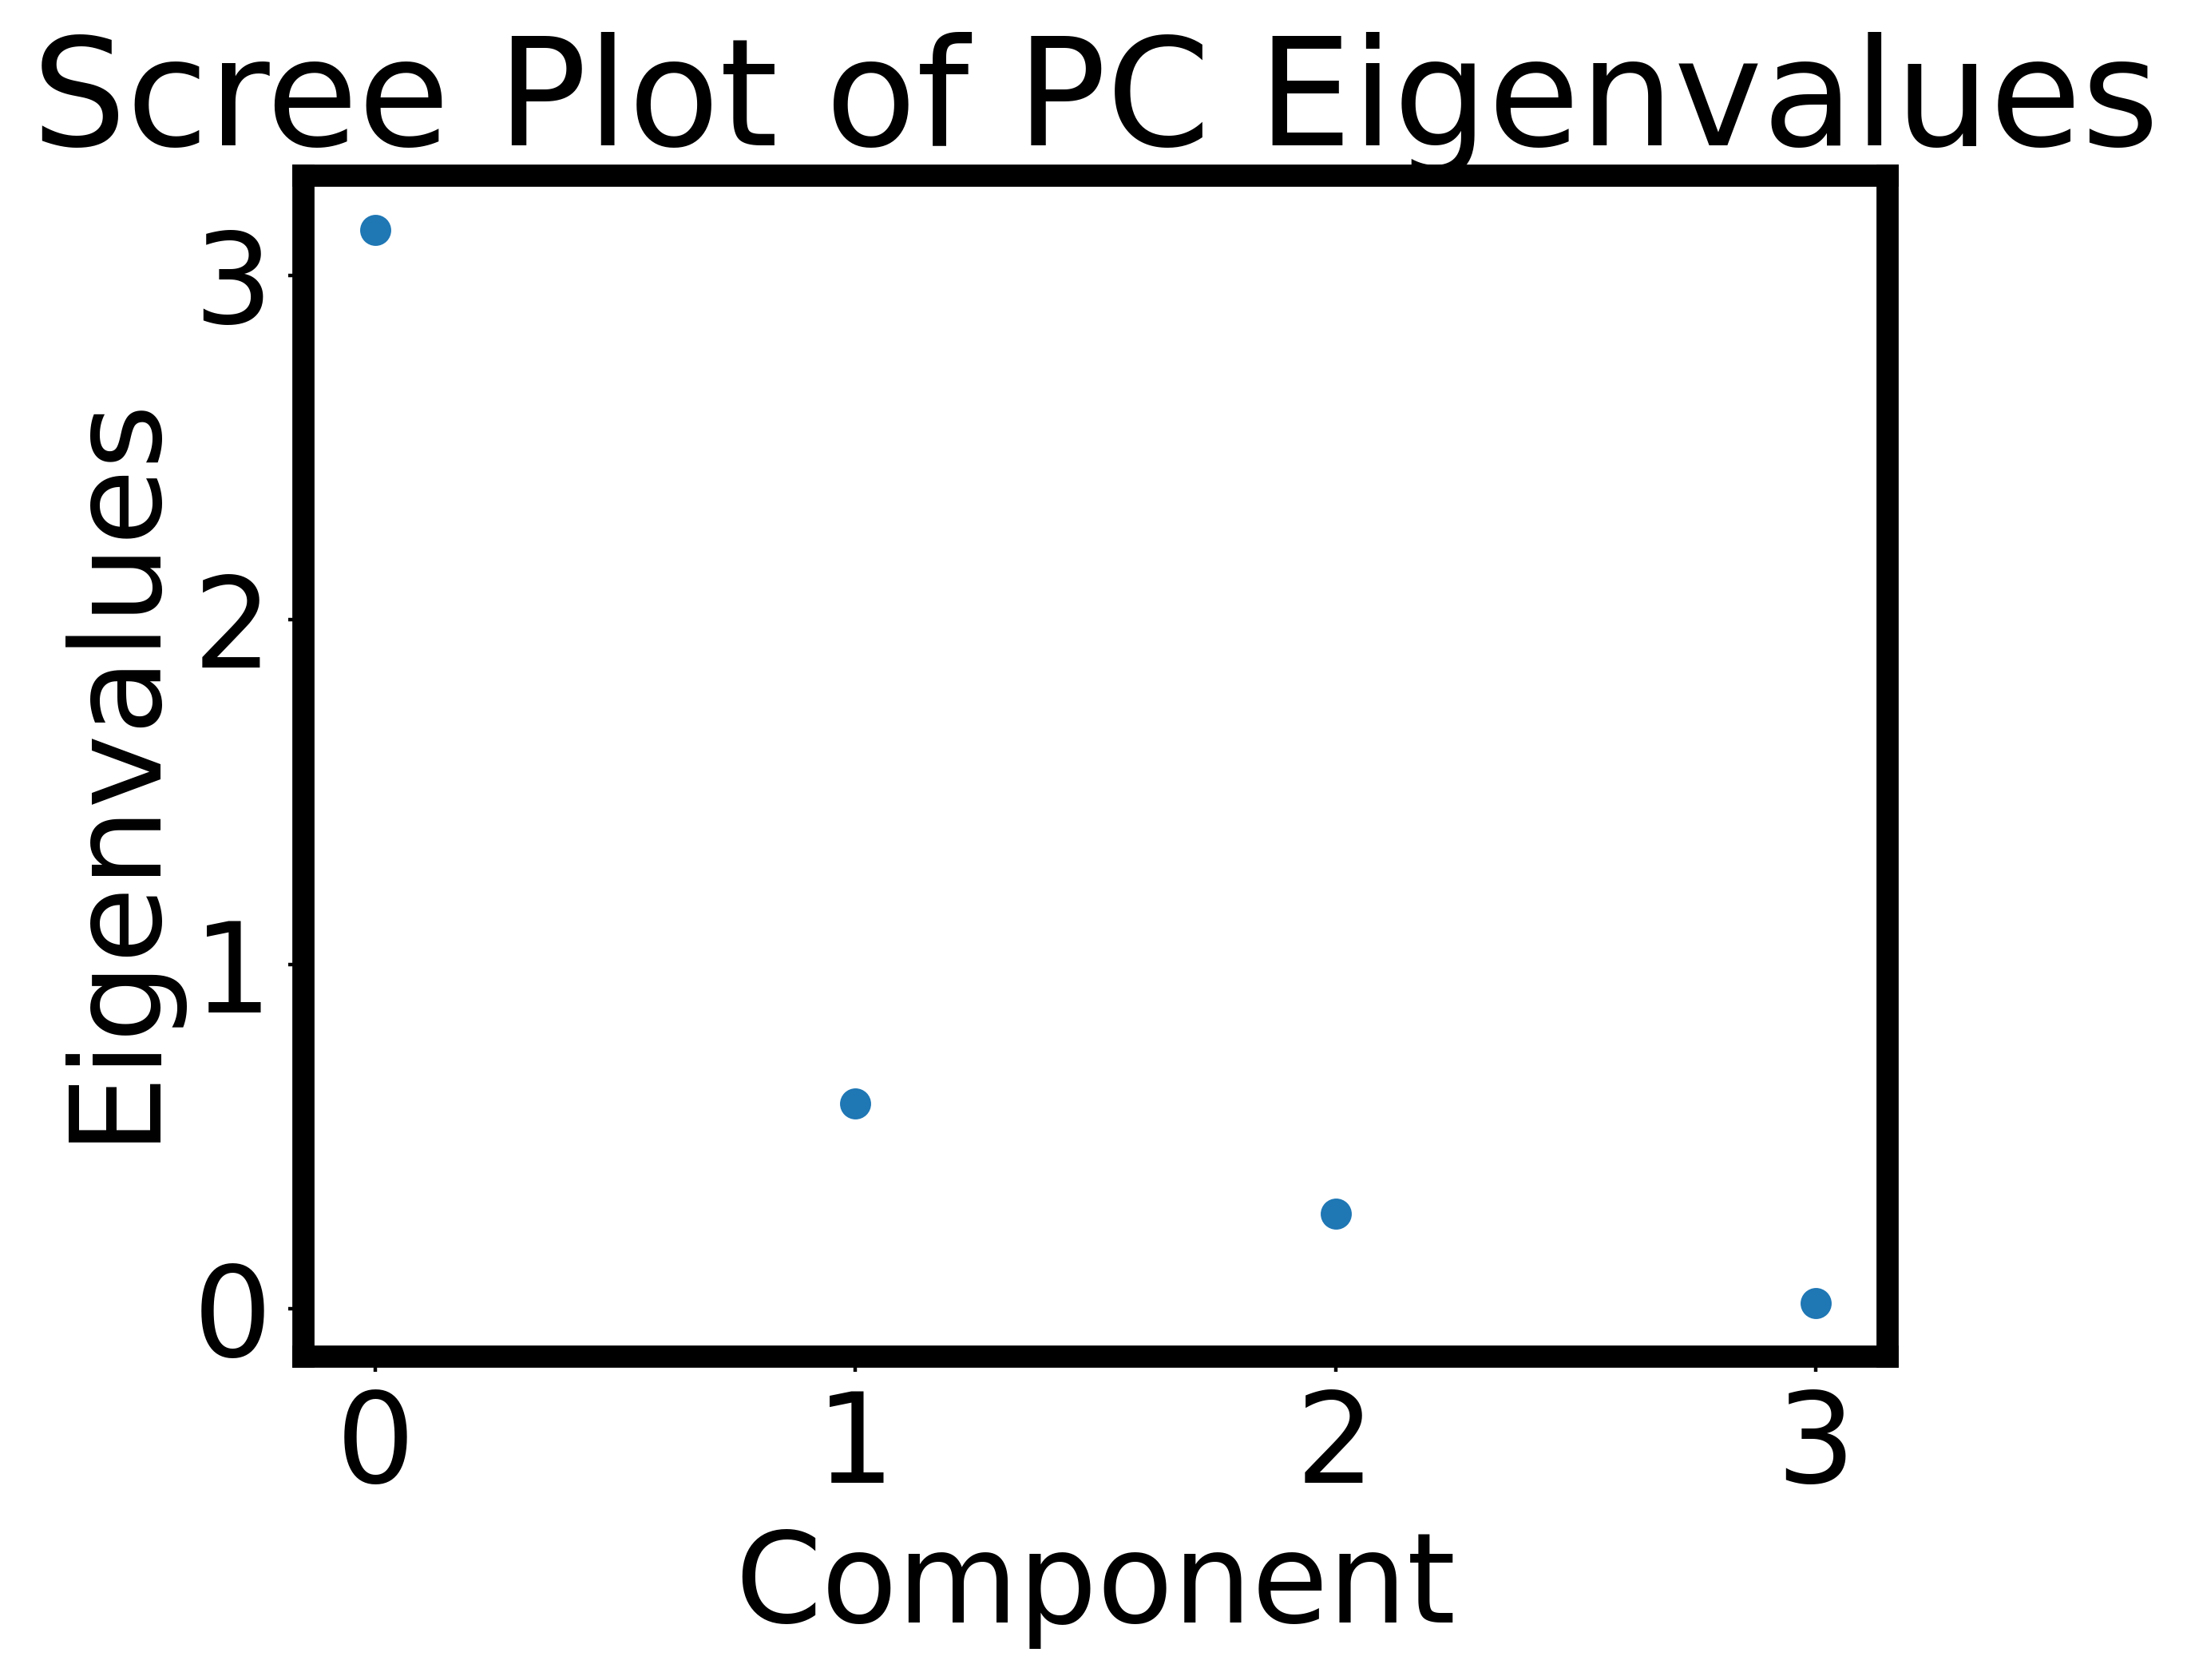

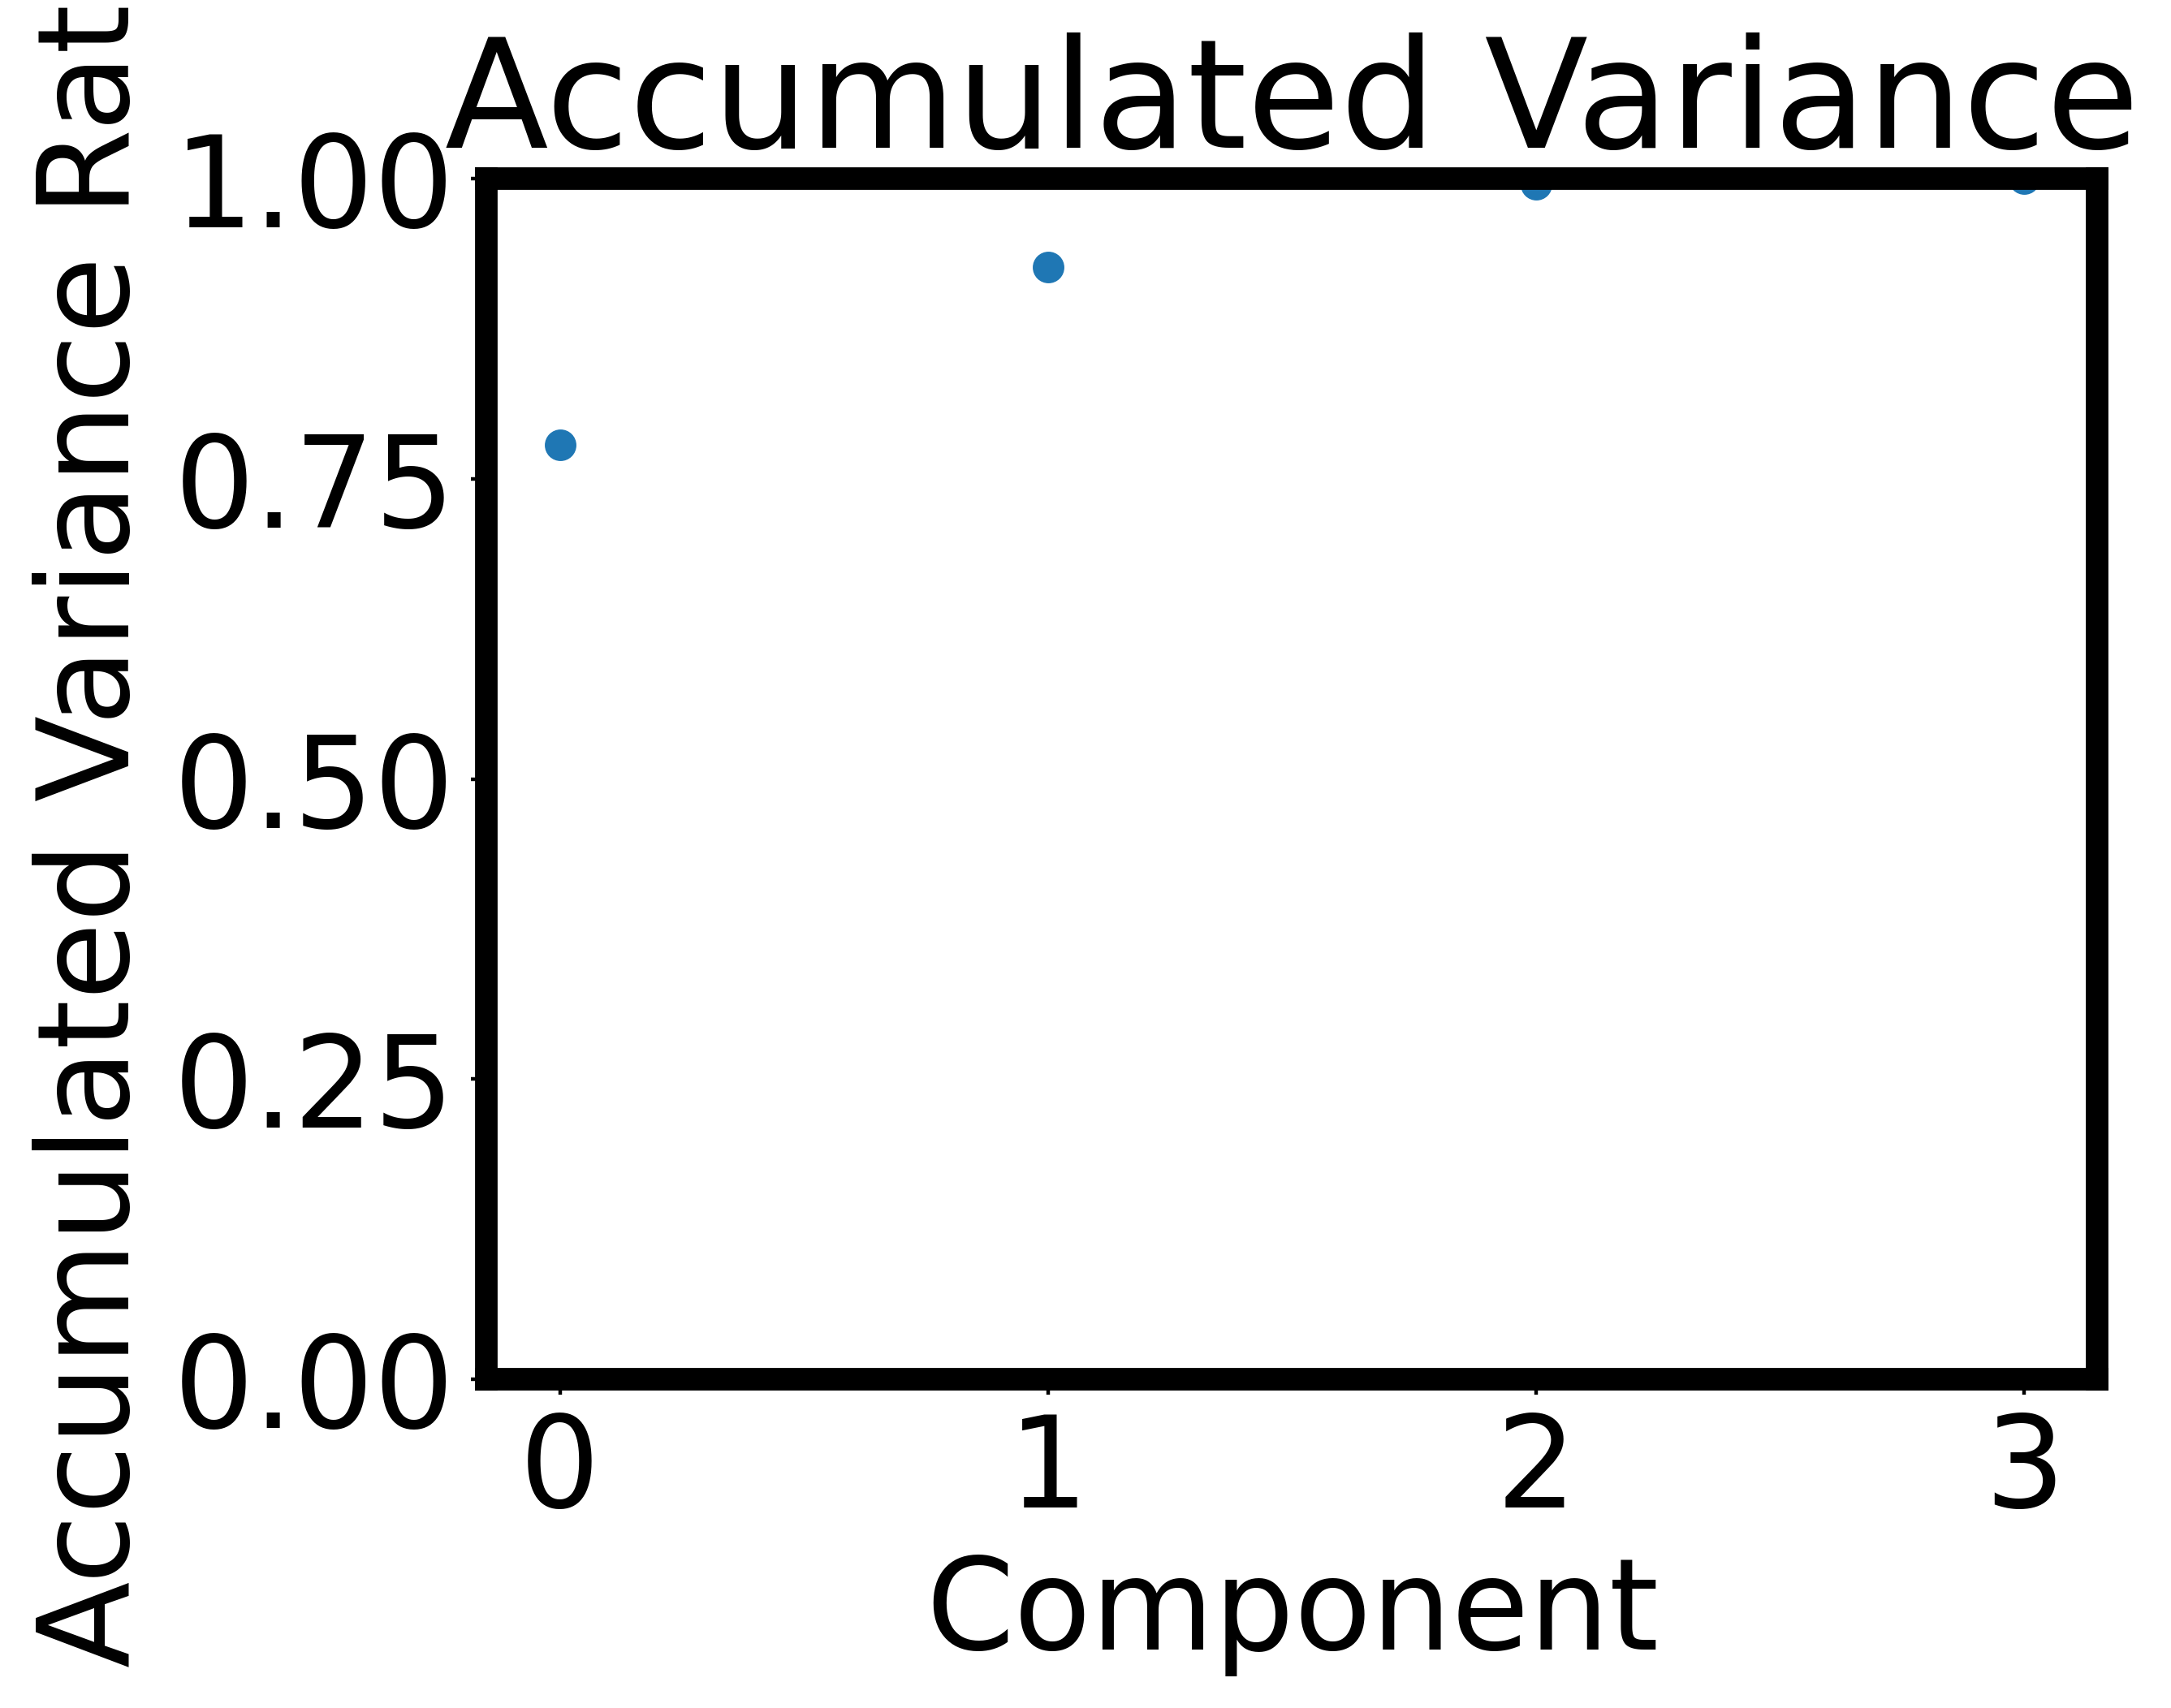

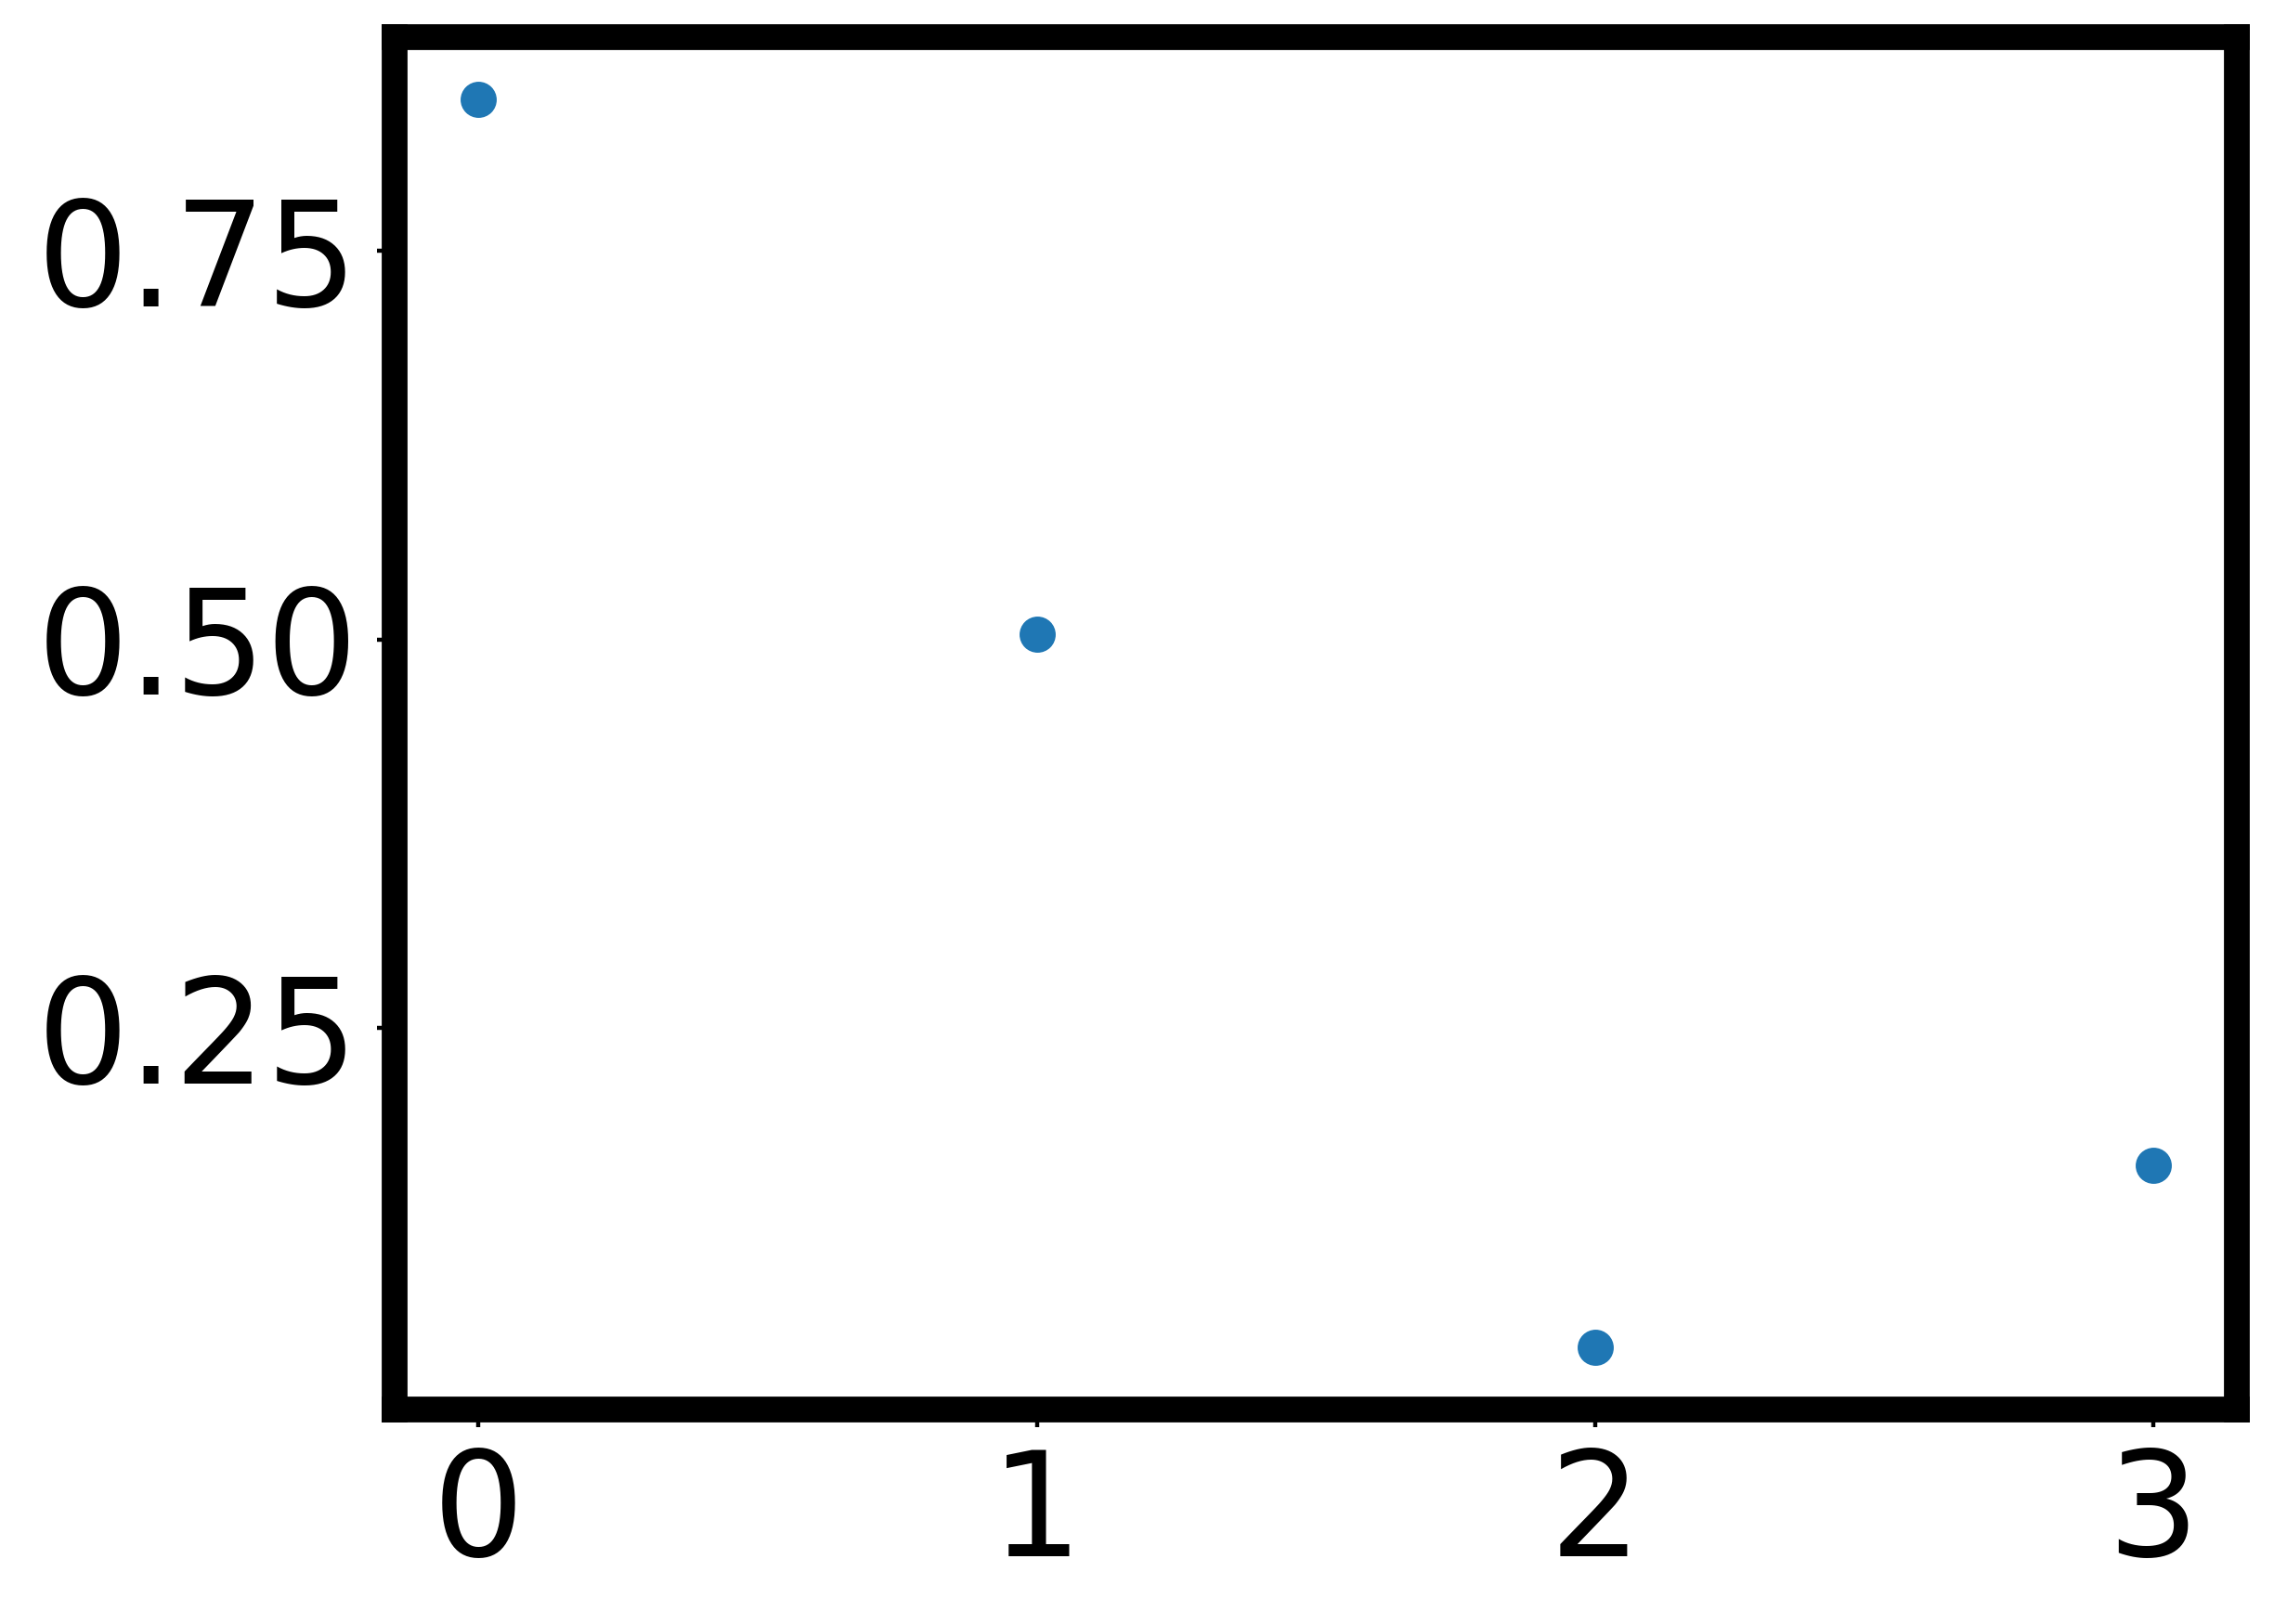

    content_replicate  labels       PC1       PC2
0               pos_1       2  1.885630  0.727536
1               SDS_1       0 -1.018617  0.079275
2               166_1       0 -1.016672  0.080169
3               197_1       2  3.045624  1.203850
4               333_1       0 -1.024529  0.076519
..                ...     ...       ...       ...
163             269_4       0 -1.029648  0.075995
164             232_4       1  3.200088 -0.835734
165            193_41       0 -1.025507  0.076044
166             188_4       0 -1.031707  0.075792
167             118_4       1  1.172654 -2.105164

[168 rows x 4 columns]


In [11]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pickle as pkl
import mpl_axes_aligner
import plotly.express as px
import pandas as pd

plt.rcParams['figure.dpi'] = 400

x = StandardScaler().fit_transform(qsIF.get_numpy_dataset('raw'))
x_m = StandardScaler().fit_transform(qsIF.get_numpy_dataset('analysis'))
y = qsIF.get_numpy_dataset('labels')

pca = PCA().fit(x)
pca_m = PCA().fit(x_m)
skb = SelectKBest(k = 'all').fit(x, y)

pc_feature_scores = abs(pca.components_)
features = []
for i in range(len(pc_feature_scores[0])):
    features.append(np.sum(pc_feature_scores[5, i]))

plt.scatter(np.arange(len(features)), features)
plt.show()

## RAW DATA
# Scree Plot 
plt.scatter(np.arange(len(features)), pca.explained_variance_)
plt.title('Scree Plot of PC Eigenvalues')
plt.ylabel('Eigenvalues')
plt.xlabel('Component')
plt.show()

# Variance Ratio
sum = 0
accumulated_variance = []
for val in pca.explained_variance_ratio_:
    sum += val
    accumulated_variance.append(sum)

# Plot accumlation of variance
plt.scatter(np.arange(len(features)), np.array(accumulated_variance))
plt.title('Accumulated Variance')
plt.ylabel('Accumulated Variance Ratio')
plt.ylim([0, 1])
plt.xlabel('Component')
plt.show()

# Get Dataframe Version
df = qsIF.raw_dataset

# Identify Samples
x_pca = pca.transform(x)

new_df = pd.DataFrame()
new_df['content_replicate'] = df['content_replicate']
df = new_df
df.insert(1, 'labels', y, True)

for i in range(1, 3):
    df.insert(i + 1, 'PC{}'.format(i), x_pca[:, i-1], True)
    
print(df)

fig = px.scatter(df, x='PC1', y='PC2', color = 'labels', hover_data=['content_replicate'])
fig.show()

## METRICS DATA
# Scree Plot 
plt.scatter(np.arange(len(pca_m.explained_variance_)), pca_m.explained_variance_)
plt.title('Scree Plot of PC Eigenvalues')
plt.ylabel('Eigenvalues')
plt.xlabel('Component')
plt.show()

# Variance Ratio
sum = 0
accumulated_variance = []
for val in pca_m.explained_variance_ratio_:
    sum += val
    accumulated_variance.append(sum)

# Plot accumlation of variance
plt.scatter(np.arange(len(pca_m.explained_variance_)), np.array(accumulated_variance))
plt.title('Accumulated Variance')
plt.ylabel('Accumulated Variance Ratio')
plt.ylim([0, 1])
plt.xlabel('Component')
plt.show()

pc_feature_scores = abs(pca_m.components_)
features = []
for i in range(len(pc_feature_scores[0])):
    features.append(np.sum(pc_feature_scores[1, i]))

plt.scatter(np.arange(len(features)), features)
plt.show()

# Create Biplot
# Get Dataframe Version
df = qsIF.analysis_dataset

# Identify Samples
x_pca = pca_m.transform(x_m)

new_df = pd.DataFrame()
new_df['content_replicate'] = df['content_replicate']
df = new_df
df.insert(1, 'labels', y, True)

for i in range(1, 3):
    df.insert(i + 1, 'PC{}'.format(i), x_pca[:, i-1], True)
    
print(df)

fig = px.scatter(df, x='PC1', y='PC2', color = 'labels', hover_data=['content_replicate'])
fig.show()

In [12]:
### Plot Edge Cases
df = pd.read_csv('./Data/GrinderClean/combined_raw.csv')

## Raw Data
# Plot Negative-Like Samples
plt.plot(np.arange(65) * 0.75, np.squeeze(df.loc[df['content_replicate'] == '308G_7'].drop(columns='content_replicate')), c = 'red')
plt.plot(np.arange(65) * 0.75, np.squeeze(df.loc[df['content_replicate'] == '122Gx01_3'].drop(columns='content_replicate')), c = 'red')
plt.plot(np.arange(65) * 0.75, np.squeeze(df.loc[df['content_replicate'] == '15KB_2'].drop(columns='content_replicate')), c = 'red')
plt.plot(np.arange(65) * 0.75, np.squeeze(df.loc[df['content_replicate'] == '259Gx01_6'].drop(columns='content_replicate')), c = 'red')

plt.plot(np.arange(65) * 0.75, np.squeeze(df.loc[df['content_replicate'] == '428Gx01_7'].drop(columns='content_replicate')), c = 'b')
plt.plot(np.arange(65) * 0.75, np.squeeze(df.loc[df['content_replicate'] == '163Gx01_4'].drop(columns='content_replicate')), c = 'b')
plt.plot(np.arange(65) * 0.75, np.squeeze(df.loc[df['content_replicate'] == '159Gx01_2'].drop(columns='content_replicate')), c = 'b')
plt.plot(np.arange(65) * 0.75, np.squeeze(df.loc[df['content_replicate'] == '266Gx01_8'].drop(columns='content_replicate')), c = 'b')

plt.title('Most Negative-Like per Class')
plt.ylabel('Fluorescence')
plt.xlabel('Hours')
plt.show()

# Plot Positive-Like Samples
plt.plot(np.arange(65) * 0.75, np.squeeze(df.loc[df['content_replicate'] == '6Px01_4'].drop(columns='content_replicate')), c = 'red')
plt.plot(np.arange(65) * 0.75, np.squeeze(df.loc[df['content_replicate'] == '123G_1'].drop(columns='content_replicate')), c = 'red')
plt.plot(np.arange(65) * 0.75, np.squeeze(df.loc[df['content_replicate'] == '38Gx01_3'].drop(columns='content_replicate')), c = 'red')
plt.plot(np.arange(65) * 0.75, np.squeeze(df.loc[df['content_replicate'] == '123G_4'].drop(columns='content_replicate')), c = 'red')

plt.plot(np.arange(65) * 0.75, np.squeeze(df.loc[df['content_replicate'] == '70Px01_3'].drop(columns='content_replicate')), c = 'b')
plt.plot(np.arange(65) * 0.75, np.squeeze(df.loc[df['content_replicate'] == '70Px02_4'].drop(columns='content_replicate')), c = 'b')
plt.plot(np.arange(65) * 0.75, np.squeeze(df.loc[df['content_replicate'] == '65Px01_1'].drop(columns='content_replicate')), c = 'b')
plt.plot(np.arange(65) * 0.75, np.squeeze(df.loc[df['content_replicate'] == '367G_1'].drop(columns='content_replicate')), c = 'b')

plt.title('Most Positive-Like per Class')
plt.ylabel('Fluorescence')
plt.xlabel('Hours')
plt.show()


## Metrics Data
# Plot Negative-Like Samples
plt.plot(np.arange(65) * 0.75, np.squeeze(df.loc[df['content_replicate'] == '391G_4'].drop(columns='content_replicate')), c = 'red')
plt.plot(np.arange(65) * 0.75, np.squeeze(df.loc[df['content_replicate'] == '13KB_1'].drop(columns='content_replicate')), c = 'red')
plt.plot(np.arange(65) * 0.75, np.squeeze(df.loc[df['content_replicate'] == '15KB_3'].drop(columns='content_replicate')), c = 'red')
plt.plot(np.arange(65) * 0.75, np.squeeze(df.loc[df['content_replicate'] == '249Gx01_7'].drop(columns='content_replicate')), c = 'red')

plt.plot(np.arange(65) * 0.75, np.squeeze(df.loc[df['content_replicate'] == '309KB_1'].drop(columns='content_replicate')), c = 'b')
plt.plot(np.arange(65) * 0.75, np.squeeze(df.loc[df['content_replicate'] == '309KB_4'].drop(columns='content_replicate')), c = 'b')
plt.plot(np.arange(65) * 0.75, np.squeeze(df.loc[df['content_replicate'] == '308KB_3'].drop(columns='content_replicate')), c = 'b')
plt.plot(np.arange(65) * 0.75, np.squeeze(df.loc[df['content_replicate'] == '19G_5'].drop(columns='content_replicate')), c = 'b')

plt.title('Most Negative-Like per Class')
plt.ylabel('Fluorescence')
plt.xlabel('Hours')
plt.show()

# Plot Positive-Like Samples
plt.plot(np.arange(65) * 0.75, np.squeeze(df.loc[df['content_replicate'] == '72Px03_3'].drop(columns='content_replicate')), c = 'red')
plt.plot(np.arange(65) * 0.75, np.squeeze(df.loc[df['content_replicate'] == '453Gx01_2'].drop(columns='content_replicate')), c = 'red')
plt.plot(np.arange(65) * 0.75, np.squeeze(df.loc[df['content_replicate'] == '21Px03_2'].drop(columns='content_replicate')), c = 'red')
plt.plot(np.arange(65) * 0.75, np.squeeze(df.loc[df['content_replicate'] == '18Px03_3'].drop(columns='content_replicate')), c = 'red')

plt.plot(np.arange(65) * 0.75, np.squeeze(df.loc[df['content_replicate'] == '61GC_1'].drop(columns='content_replicate')), c = 'b')
plt.plot(np.arange(65) * 0.75, np.squeeze(df.loc[df['content_replicate'] == '31G_6'].drop(columns='content_replicate')), c = 'b')
plt.plot(np.arange(65) * 0.75, np.squeeze(df.loc[df['content_replicate'] == '97Gx01_5'].drop(columns='content_replicate')), c = 'b')
plt.plot(np.arange(65) * 0.75, np.squeeze(df.loc[df['content_replicate'] == '55GCx01_2'].drop(columns='content_replicate')), c = 'b')

plt.title('Most Positive-Like per Class')
plt.ylabel('Fluorescence')
plt.xlabel('Hours')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './Data/GrinderClean/combined_raw.csv'

In [ ]:
from tensorflow import keras
model = keras.models.load_model('./SavedModels/Raw/mlp.h5')
keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=200,
    show_layer_activations=True,
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
